### References:
BandCamp Notebook (Derek Everett):   
https://github.com/derekeverett/simple_bayes_with_GP/blob/master/BANDCamp2020_Bayes_Param_Est_GP.ipynb  

Emulator with noise:  
https://gpy.readthedocs.io/en/deploy/GPy.likelihoods.html#module-GPy.likelihoods.gaussian  

ptemcee:  
https://emcee.readthedocs.io/en/develop/user/pt/

Plotting contours:  
https://stackoverflow.com/questions/45043833/curve-defined-by-the-intersection-between-two-scattered-point-surfaces-sampled  


In [1]:
from scipy.optimize import minimize
import corner
import numpy as np
#import ptemcee
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from emukit.core import ParameterSpace, ContinuousParameter
from GPy.models import MultioutputGP
from GPy import likelihoods
from emukit.model_wrappers import GPyMultiOutputWrapper
from GPy.kern import RBF, White
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from GPy.kern.src.multioutput_kern import MultioutputKern
import seaborn as sns

import random
random.seed(42)

from emukit.experimental_design.acquisitions.contour_MultiObs_min import contourMinEI
from emukit.experimental_design.acquisitions.contour_1D import contour1D
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.core.optimization import GradientAcquisitionOptimizer

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pyDOE import *
from scipy.stats import norm
from scipy import integrate
import corner

import math
%matplotlib inline 

from emcee.ptsampler import PTSampler

# set seaborn style
sns.set_style("white")

In [2]:
# 3d plot function
def makeplot(position,x,y,z,title):
    ax = fig.add_subplot(position,projection='3d')
    ax.scatter(x, y, z, c=z, label=title)
    ax.legend()
    return ax

### Define Test Functions

In [3]:
true_param = np.array([0.2,0.8]).reshape(1,2)

[array([[3.98846086]]), array([[43.29208585]])]
[array([[4.06756126]]), array([[43.19562041]])]


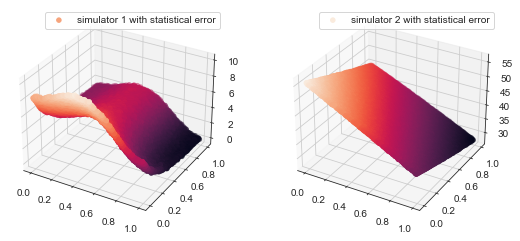

In [4]:
lb = [0,0]
ub = [1,1]
parameter_space = ParameterSpace([ContinuousParameter('x1', lb[0], ub[0]),ContinuousParameter('x2', lb[1], ub[1])])
pi = math.pi
a = 1
b = 5.1 / (4 * pi **2)
c = 5 / pi
r = 6
s = 10
t = 1 / (8*pi)
noise = 0.1 # statistical noise

# https://www.sfu.ca/~ssurjano/limetal02non.html
# https://www.sfu.ca/~ssurjano/branin.html

def f(X): # with statistical noise
    y1 = 1/6 * ((30+5*X[:,0]*np.sin(5*X[:,0])) * (4+np.exp(-5*X[:,1]))-100) +  np.random.normal(0,noise,X.shape[0])
    y2 = a * (X[:,1] - b * X[:,0]**2 + c * X[:,0] - r)**2 + s*(1-t) * np.cos(X[:,0]) + s +  np.random.normal(0,noise,X.shape[0])
    return [y1.reshape(-1,1),y2.reshape(-1,1)]

def f_noNoise(X): # noise-free
    y1 = 1/6 * ((30+5*X[:,0]*np.sin(5*X[:,0])) * (4+np.exp(-5*X[:,1]))-100)
    y2 = a * (X[:,1] - b * X[:,0]**2 + c * X[:,0] - r)**2 + s*(1-t) * np.cos(X[:,0]) + s
    return [y1.reshape(-1,1),y2.reshape(-1,1)]

# for plotting contours
def l(x, y):
    return 1/6 * ((30+5*x*np.sin(5*x)) * (4+np.exp(-5*y))-100)

def g(x, y):
    return a * (y - b * x**2 + c * x - r)**2 + s*(1-t) * np.cos(x) + s

a_list = f_noNoise(true_param)
w_list = [0.5, 0.5] # not in use for minEI criterion

print(a_list)
print(f(true_param))

axis1 = np.arange(lb[0], ub[0], 0.01)
axis2 = np.arange(lb[1], ub[1], 0.01)

B, D = np.meshgrid(axis1, axis2)
X_plot = np.array([B.flatten(),D.flatten()]).transpose()
# side by side 3d plot
fig = plt.figure(figsize=(9,4))
makeplot(121, B.flatten(), D.flatten(), f(X_plot)[0].flatten(), 'simulator 1 with statistical error')
makeplot(122, B.flatten(), D.flatten(), f(X_plot)[1].flatten(), 'simulator 2 with statistical error')
plt.show()


### Set experimental data & uniform prior

In [5]:
y_exp = np.array(a_list).flatten().reshape(1,2) # oracle target
dy_exp = np.array([[0.1,0.1]]) # experimental noise (fixed)

In [6]:
theta_min = 0
theta_max = 1
ndim = len(a_list)

# independent uniform prior
def log_flat_prior(theta):
    # The parameters are stored as a vector of values, so unpack them
    theta1, theta2 = theta
    # We're using only uniform priors in [0,1]
    if (theta_min <= theta1) and (theta1 <= theta_max) and (theta_min <= theta2) and (theta2 <= theta_max):
        return 0. # log(1)
    else:
        return -np.inf  # log(0)
    
# log_flat_prior = np.vectorize(log_flat_prior)

### 1. Target posterior (using simulator directly)

In [7]:
def sim_output(xx, obsno):
    """This generates output from simulator."""
    X = xx.reshape(-1, ndim)
    y = f(X)[obsno]
    return y

# define log likelihood
def log_likelihood_sim(theta, y_exp, dy_exp):
    '''Log-likelihood for data y_exp.'''
    #use our GP emulator for prediction
    log_lik = 0
    
    for obs in range(y_exp.shape[1]): # number of observables
        y_pred = sim_output(theta, obs) # simulator, no simulator uncertainty
        sigma2 = dy_exp.flatten()[obs]**2. 
        log_lik = log_lik - 0.5*np.log(2.*np.pi*sigma2) -0.5*( (y_pred - y_exp.flatten()[obs])**2 / sigma2 )
        
    return log_lik

#posterior using flat prior
def log_posterior_flat_prior_sim(theta, y_exp, dy_exp):
    '''Log posterior for data y_exp and uncertainties 
        dy_exp given parameter array theta, assuming prior is flat.'''
    return log_flat_prior(theta) + log_likelihood_sim(theta, y_exp, dy_exp)

In [8]:
def get_values_aroud(param,fraction,n_samples):
    """This returns 1d array of values near the parameter
    acording the fraction specified """
    x = np.linspace(param - param*fraction, param + param*fraction, n_samples)
    return x
    

In [9]:
D.shape

(100, 100)

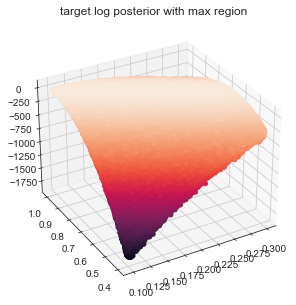

In [10]:
# plot target log posterior
axis1 = get_values_aroud(true_param[0,0],0.5,1000)
axis2 = get_values_aroud(true_param[0,1],0.5,1000)

B, D = np.meshgrid(axis1, axis2)
X_plot = np.array([B.flatten(),D.flatten()]).transpose()

target_logposterior = [log_posterior_flat_prior_sim(x, y_exp, dy_exp) for x in X_plot]
tlp = np.array(target_logposterior).flatten()

fig = plt.figure(figsize = (5,5))
ax = fig.gca(projection='3d')
ax.scatter(B.flatten(), D.flatten(), tlp, c=tlp )
#ax.contour(B, D, np.abs(tlp-max(tlp)).reshape(D.shape[0],D.shape[1]), levels=10,\
#           zdir='z', colors='blue')
plt.title('target log posterior with max region')
ax.view_init(30, 240)
plt.show()

# # export data to check logposterior (note: cannot use f() to compare, different noise, here we only compare when f is replaced by f_noNoise in sim_output function)
# x_toR = pd.DataFrame(X_plot)
# x_toR.to_csv('sim_calc_logposterior_x.csv', index=False)
# y_toR = pd.DataFrame(np.array([f_noNoise(X_plot)[0].flatten(),f_noNoise(X_plot)[1].flatten()]).T)
# y_toR.to_csv('sim_calc_logposterior_y.csv', index=False)
# tlp_toR = pd.DataFrame(tlp)
# tlp_toR.to_csv('sim_calc_logposterior.csv', index=False)

In [11]:
# ptemcee
ntemps = 10
nwalkers = 20
# starting_guesses = np.ones(ntemps*nwalkers*ndim).reshape(ntemps,nwalkers,ndim)*0.5 + np.random.rand(ntemps,nwalkers,ndim) * 0.1
starting_guesses = np.random.uniform(size=(ntemps,nwalkers,ndim))
sampler = PTSampler(nwalkers, ndim, log_likelihood_sim, log_flat_prior, ntemps=ntemps, loglargs=[y_exp, dy_exp])

# burn in
for p, lnprob, lnlike in sampler.sample(starting_guesses, iterations=100):
    pass
sampler.reset()

# record every 10
for p, lnprob, lnlike in sampler.sample(p, iterations=500, thin=5):
    pass

# resulting chains
assert sampler.chain.shape == (ntemps, nwalkers, 100, ndim)

# Chain has shape (ntemps, nwalkers, nsteps, ndim)
# Zero temperature mean:
mu0 = np.mean(np.mean(sampler.chain[0,:,:,:], axis=0), axis=0)

# Longest autocorrelation length (over any temperature)
max_acl = np.max(sampler.acor)

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wi

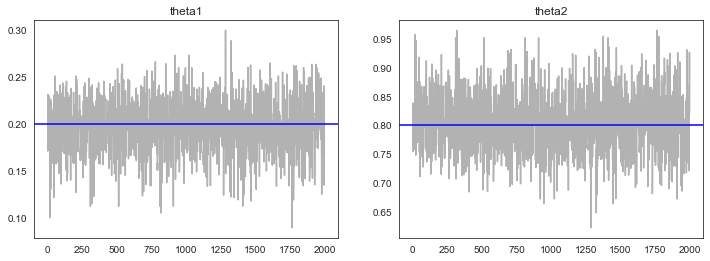

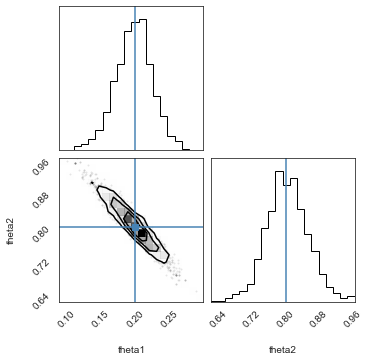

In [12]:
# plots & save data for R analysis
sim_T0chain = sampler.chain[0,...].reshape(-1,ndim)
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(sim_T0chain[:,0], '-', color='k', alpha=0.3)
ax1.axhline(y=true_param[0][0], color='blue')
ax1.title.set_text('theta1')

ax2.plot(sim_T0chain[:,1], '-', color='k', alpha=0.3)
ax2.axhline(y=true_param[0][1], color='blue')
ax2.title.set_text('theta2')
plt.show()

tmp = corner.corner(sim_T0chain, labels=['theta1','theta2'], 
                truths=[true_param[0][0],true_param[0][1]])

MCMC_sim = pd.DataFrame(sim_T0chain)
MCMC_sim.to_csv('2d_2obs_Branin_LIM_MCMCsim.csv', index=False)

### 2. Proposed Sequential Design Method (acquisition with no noise)

#### Repeat 10 times

In [13]:
n_init = 10
n_total = 40
alpha_list = [[0.1, 0.1], [1, 1],[10,10]]

$\ln p(y_{i}|\lambda(f_{i})) = -\frac{N \ln 2\pi}{2} - \frac{\ln |K|}{2} - \frac{(y_{i} - \lambda(f_{i}))^{T}\sigma^{-2}(y_{i} - \lambda(f_{i}))}{2}$

In [24]:
BB.flatten()

array([0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99])

In [32]:
len(Y)

2

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/10, f = 32.56612431356112
Optimization restart 2/10, f = 36.67219610292734
Optimization restart 3/10, f = 32.56612445067321
Optimization restart 4/10, f = 44.232521738159036
Optimization restart 5/10, f = 32.56612431371985
Optimization restart 6/10, f = 43.59363266134821
Optimization restart 7/10, f = 32.56612431495947
Optimization restart 8/10, f = 32.56612431494716
Optimization restart 9/10, f = 44.85442214213457
Optimization restart 10/10, f = 44.23252173809481

Name : gp
Objective : 32.56612431356112
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    19.685152269841634  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6268006166231449  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |     6681.00681

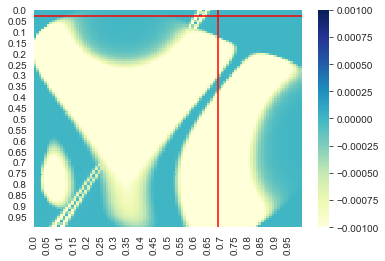

[array([[0.68749404, 0.02803425]]), array([[9.44405137e-18]])]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 33.357564573101044
Optimization restart 2/10, f = 33.35756456904593
Optimization restart 3/10, f = 34.025331391367246
Optimization restart 4/10, f = 33.35756456913398
Optimization restart 5/10, f = 36.69647128869682
Optimization restart 6/10, f = 39.499880651158136
Optimization restart 7/10, f = 33.35756456900687
Optimization restart 8/10, f = 49.60532981792242
Optimization restart 9/10, f = 38.16855790265129
Optimization restart 10/10, f = 33.35914050999879

Name : gp
Objective : 33.35756456900687
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     22.91249646444516  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6590906106526501  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |     6204.957

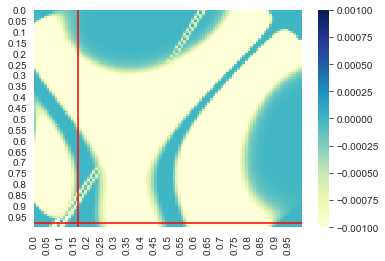

[array([[0.16669517, 0.98186775]]), array([[3.56737332e-18]])]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 37.847228142264996
Optimization restart 2/10, f = 48.02691456373475
Optimization restart 3/10, f = 33.50056916849374
Optimization restart 4/10, f = 47.528422517108275
Optimization restart 5/10, f = 46.79239030632246
Optimization restart 6/10, f = 33.500569170912456
Optimization restart 7/10, f = 33.99906122439643
Optimization restart 8/10, f = 37.75014992521862
Optimization restart 9/10, f = 65.57923149443846
Optimization restart 10/10, f = 33.501640997593796

Name : gp
Objective : 33.50056916849374
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    22.509554687942465  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6583714581243331  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |     6592.89

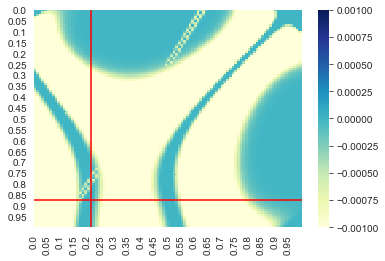

[array([[0.21331162, 0.87640863]]), array([[6.17743402e-20]])]
Optimization restart 1/10, f = 33.63625689600852
Optimization restart 2/10, f = 32.69768485445042
Optimization restart 3/10, f = 33.63625689569619
Optimization restart 4/10, f = 32.697684847512875
Optimization restart 5/10, f = 32.697684849107354
Optimization restart 6/10, f = 33.63625689522413
Optimization restart 7/10, f = 32.69768484735423
Optimization restart 8/10, f = 32.69768486851464
Optimization restart 9/10, f = 32.69768484684577
Optimization restart 10/10, f = 32.697688846910026

Name : gp
Objective : 32.69768484684577
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     21.94523988086911  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6314047766911481  |      +ve      |        
  M

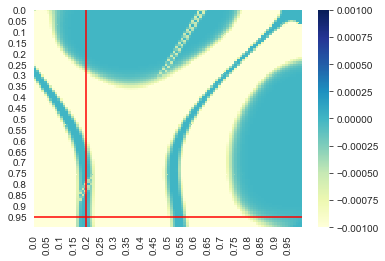

[array([[0.19540245, 0.95322531]]), array([[1.38800859e-42]])]
Optimization restart 1/10, f = 30.557093156394664
Optimization restart 2/10, f = 30.929371850824076
Optimization restart 3/10, f = 52.06974179137828
Optimization restart 4/10, f = 30.929371850258942
Optimization restart 5/10, f = 34.03031898757003
Optimization restart 6/10, f = 37.13215095896254
Optimization restart 7/10, f = 30.92937184995767
Optimization restart 8/10, f = 72.79189802611496
Optimization restart 9/10, f = 30.55709315793856
Optimization restart 10/10, f = 30.55711014236042

Name : gp
Objective : 30.557093156394664
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     18.367274393960358  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.4560338519831605  |      +ve      |        

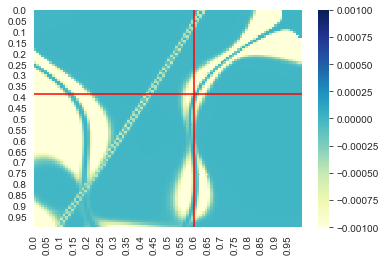

[array([[0.59983133, 0.38771715]]), array([[9.18053858e-260]])]
Optimization restart 1/10, f = 32.659831442314356
Optimization restart 2/10, f = 32.65983090834169
Optimization restart 3/10, f = 32.65983090910325
Optimization restart 4/10, f = 30.77404978781481
Optimization restart 5/10, f = 73.4897718411257
Optimization restart 6/10, f = 30.774049777238634
Optimization restart 7/10, f = 53.471331699253554
Optimization restart 8/10, f = 30.774049766539
Optimization restart 9/10, f = 30.774049767059097
Optimization restart 10/10, f = 30.774133320127106

Name : gp
Objective : 30.774049766539
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    20.810759371264314  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.588692659259088  |      +ve      |        
  Mul

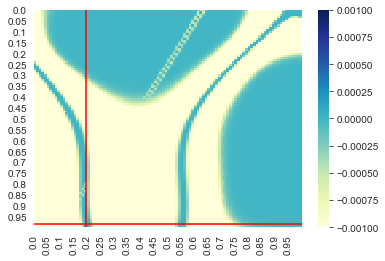

[array([[0.19508489, 0.98556763]]), array([[6.33744549e-69]])]
Optimization restart 1/10, f = 30.85557492380015
Optimization restart 2/10, f = 75.43691252527711
Optimization restart 3/10, f = 30.855574923114702
Optimization restart 4/10, f = 29.153833294123373
Optimization restart 5/10, f = 29.15383329122492
Optimization restart 6/10, f = 29.153833291134408
Optimization restart 7/10, f = 29.15383329507872
Optimization restart 8/10, f = 30.855574923016544
Optimization restart 9/10, f = 29.153833291163064
Optimization restart 10/10, f = 29.15385040181702

Name : gp
Objective : 29.153833291134408
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     19.81498341009374  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.5528040525563835  |      +ve      |        


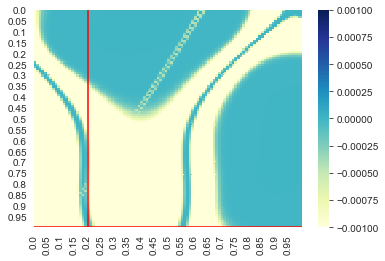

[array([[0.20259219, 0.99989051]]), array([[5.7721526e-105]])]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 25.795221142321363
Optimization restart 2/10, f = 43.33799115314175
Optimization restart 3/10, f = 25.795220948717525
Optimization restart 4/10, f = 25.795220949252112
Optimization restart 5/10, f = 25.79522094955289
Optimization restart 6/10, f = 25.7952209498273
Optimization restart 7/10, f = 25.795220947764196
Optimization restart 8/10, f = 25.795221086185308
Optimization restart 9/10, f = 25.79522094813636
Optimization restart 10/10, f = 25.795289684447877

Name : gp
Objective : 25.795220947764196
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     13.996876141459493  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.40103037185016666  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |      6

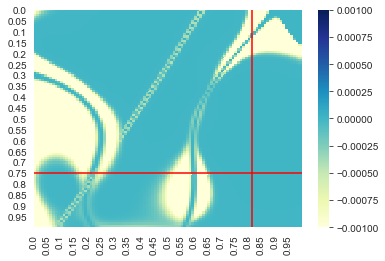

[array([[0.81391707, 0.75054338]]), array([[-0.]])]
Optimization restart 1/10, f = 26.959915587716793
Optimization restart 2/10, f = 26.959915590964894
Optimization restart 3/10, f = 26.959915621174858
Optimization restart 4/10, f = 26.959915594545787
Optimization restart 5/10, f = 26.95991559114224
Optimization restart 6/10, f = 51.01286233720483
Optimization restart 7/10, f = 26.959915587900717
Optimization restart 8/10, f = 26.959915588638577
Optimization restart 9/10, f = 26.959915597615158
Optimization restart 10/10, f = 26.959916071492984

Name : gp
Objective : 26.959915587716793
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    18.181394197276354  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.5204230590718157  |      +ve      |        
  Multio

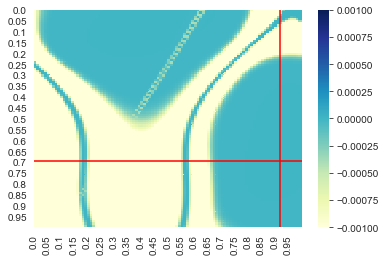

[array([[0.92061637, 0.69602281]]), array([[-0.]])]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 25.241072406337295
Optimization restart 2/10, f = 46.233406484763066
Optimization restart 3/10, f = 25.241072408922097
Optimization restart 4/10, f = 45.313401262618584
Optimization restart 5/10, f = 25.241072406028948
Optimization restart 6/10, f = 25.24107241696916
Optimization restart 7/10, f = 25.241072406229613
Optimization restart 8/10, f = 25.24107243584222
Optimization restart 9/10, f = 25.24107241117234
Optimization restart 10/10, f = 25.24110871897251

Name : gp
Objective : 25.241072406028948
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |   16.997455693537276  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |  0.48281406245110964  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |     6791.95

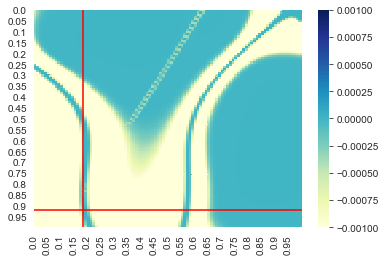

[array([[0.18395773, 0.91981137]]), array([[2.07089018e-31]])]
Optimization restart 1/10, f = 22.826070278332345
Optimization restart 2/10, f = 22.82607026963295
Optimization restart 3/10, f = 22.826070270881672
Optimization restart 4/10, f = 22.82607027270675
Optimization restart 5/10, f = 22.826070269036116
Optimization restart 6/10, f = 22.826070270464584
Optimization restart 7/10, f = 22.82607027039932
Optimization restart 8/10, f = 22.826070269972938
Optimization restart 9/10, f = 22.826070268235412
Optimization restart 10/10, f = 22.826076546373116

Name : gp
Objective : 22.826070268235412
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    15.540814510409652  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.4391349191238473  |      +ve      |       

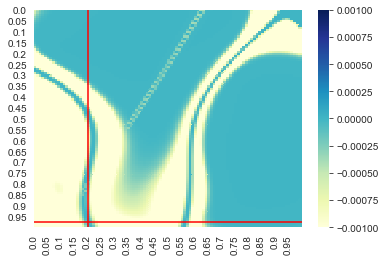

[array([[0.20239608, 0.97450613]]), array([[3.64413904e-116]])]
Optimization restart 1/10, f = 20.382768120731512
Optimization restart 2/10, f = 20.34811736241511
Optimization restart 3/10, f = 20.3827681662477
Optimization restart 4/10, f = 20.38276811179351
Optimization restart 5/10, f = 20.382768110834412
Optimization restart 6/10, f = 20.382768113940656
Optimization restart 7/10, f = 20.34811734702692
Optimization restart 8/10, f = 20.348117352387916
Optimization restart 9/10, f = 20.348117341074087
Optimization restart 10/10, f = 20.38279036194902

Name : gp
Objective : 20.348117341074087
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     12.103082106255815  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.3406260998574096  |      +ve      |      

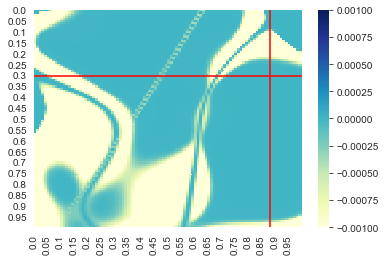

[array([[0.88011161, 0.3027532 ]]), array([[-0.]])]
Optimization restart 1/10, f = 20.183871407315074
Optimization restart 2/10, f = 20.183871405778376
Optimization restart 3/10, f = 20.183871408078218
Optimization restart 4/10, f = 20.18387140834176
Optimization restart 5/10, f = 20.183871909335544
Optimization restart 6/10, f = 20.183871412137492
Optimization restart 7/10, f = 20.183871476077172
Optimization restart 8/10, f = 20.183871407242144
Optimization restart 9/10, f = 20.183871408656216
Optimization restart 10/10, f = 20.183997156414975

Name : gp
Objective : 20.183871405778376
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    12.348981503729137  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.3417018139491213  |      +ve      |        
  Multi

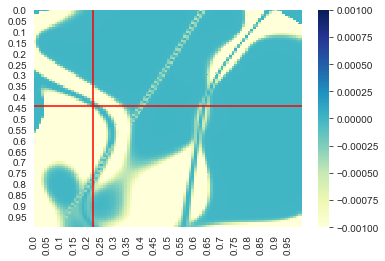

[array([[0.22120672, 0.44047328]]), array([[2.01899451e-314]])]
Optimization restart 1/10, f = 20.592122165793008
Optimization restart 2/10, f = 20.592122146767963
Optimization restart 3/10, f = 20.592122153465944
Optimization restart 4/10, f = 20.592122144620724
Optimization restart 5/10, f = 20.592122192798513
Optimization restart 6/10, f = 20.59212216381811
Optimization restart 7/10, f = 20.592122150693974
Optimization restart 8/10, f = 20.59212214754588
Optimization restart 9/10, f = 20.592122144122293
Optimization restart 10/10, f = 20.595617809417774

Name : gp
Objective : 20.592122144122293
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |        16.57372132263  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.4286202460027611  |      +ve      |     

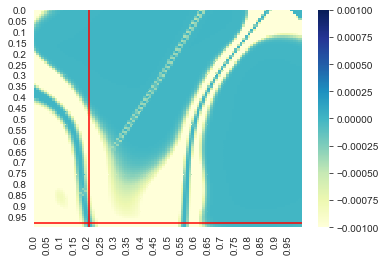

[array([[0.20431236, 0.97933572]]), array([[2.80014189e-114]])]
Optimization restart 1/10, f = 18.21978830564055
Optimization restart 2/10, f = 18.17969981139523
Optimization restart 3/10, f = 18.21978836849693
Optimization restart 4/10, f = 18.1796998049072
Optimization restart 5/10, f = 18.219788302863613
Optimization restart 6/10, f = 18.21978830301054
Optimization restart 7/10, f = 18.179699804155078
Optimization restart 8/10, f = 18.219788299691054
Optimization restart 9/10, f = 18.21978830065047
Optimization restart 10/10, f = 18.219797703532315

Name : gp
Objective : 18.179699804155078
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     12.76852353888891  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.3397304212744409  |      +ve      |        
 

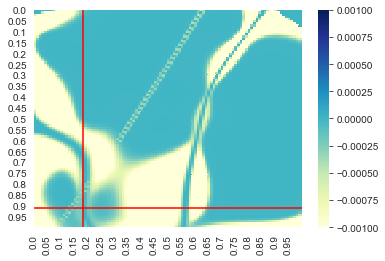

[array([[0.18513316, 0.91033004]]), array([[8.44271314e-28]])]
Optimization restart 1/10, f = 16.84221028275757
Optimization restart 2/10, f = 16.84221039386719
Optimization restart 3/10, f = 16.84221028788417
Optimization restart 4/10, f = 16.842210269419297
Optimization restart 5/10, f = 16.842210281606008
Optimization restart 6/10, f = 16.842210273934477
Optimization restart 7/10, f = 16.842210268189
Optimization restart 8/10, f = 16.842210268563
Optimization restart 9/10, f = 16.842210269719736
Optimization restart 10/10, f = 16.84258350655322

Name : gp
Objective : 16.842210268189
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    16.262741970993062  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.4178882375510384  |      +ve      |        
  Multio

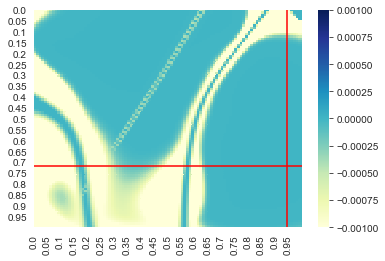

[array([[0.94345881, 0.72070273]]), array([[-0.]])]
Optimization restart 1/10, f = 14.496225755913429
Optimization restart 2/10, f = 14.496225752847216
Optimization restart 3/10, f = 14.496225751249888
Optimization restart 4/10, f = 14.496225752888222
Optimization restart 5/10, f = 14.496225762729338
Optimization restart 6/10, f = 14.496225774783596
Optimization restart 7/10, f = 14.49622576313071
Optimization restart 8/10, f = 14.496225869055152
Optimization restart 9/10, f = 14.496225762342988
Optimization restart 10/10, f = 14.496237617165669

Name : gp
Objective : 14.496225751249888
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    15.784907788942157  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.40937248320011305  |      +ve      |        
  Multi

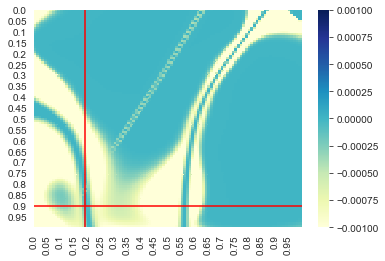

[array([[0.1926026 , 0.90268376]]), array([[4.93450257e-31]])]
Optimization restart 1/10, f = 14.366051215698633
Optimization restart 2/10, f = 14.366051216350051
Optimization restart 3/10, f = 14.366051215578423
Optimization restart 4/10, f = 14.366051214286081
Optimization restart 5/10, f = 14.36605121572957
Optimization restart 6/10, f = 14.36605121573578
Optimization restart 7/10, f = 14.366051255837036
Optimization restart 8/10, f = 14.366051215395899
Optimization restart 9/10, f = 14.366051215886777
Optimization restart 10/10, f = 14.366575940931696

Name : gp
Objective : 14.366051214286081
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     15.32522436670339  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.39912100506323106  |      +ve      |      

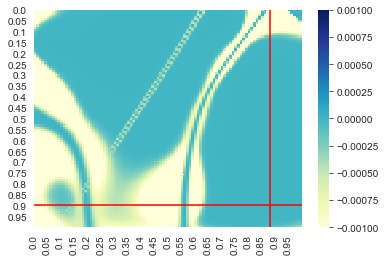

[array([[0.88243227, 0.89887047]]), array([[-0.]])]
Optimization restart 1/10, f = 13.219485863959605
Optimization restart 2/10, f = 13.219485864598298
Optimization restart 3/10, f = 13.219485865806448
Optimization restart 4/10, f = 13.219485865615823
Optimization restart 5/10, f = 13.219485880485422
Optimization restart 6/10, f = 13.219485899664662
Optimization restart 7/10, f = 13.219485864602973
Optimization restart 8/10, f = 13.219485877529095
Optimization restart 9/10, f = 13.219485862474983
Optimization restart 10/10, f = 13.219769290466061

Name : gp
Objective : 13.219485862474983
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    17.054262831323282  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.43556745172730615  |      +ve      |        
  Mult

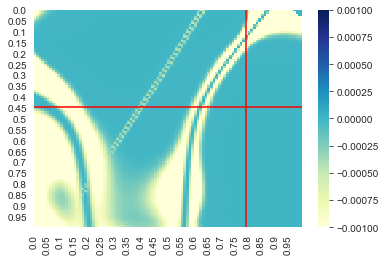

[array([[0.79180186, 0.44835942]]), array([[-0.]])]
Optimization restart 1/10, f = 11.43726741674697
Optimization restart 2/10, f = 11.437267414946213
Optimization restart 3/10, f = 11.437267415614748
Optimization restart 4/10, f = 11.437267422411573
Optimization restart 5/10, f = 11.43726741558553
Optimization restart 6/10, f = 11.437267414084097
Optimization restart 7/10, f = 11.437267461975075
Optimization restart 8/10, f = 11.437267425594037
Optimization restart 9/10, f = 11.437267415879695
Optimization restart 10/10, f = 11.438611265228992

Name : gp
Objective : 11.437267414084097
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    17.085766639116468  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.4366236191807597  |      +ve      |        
  Multio

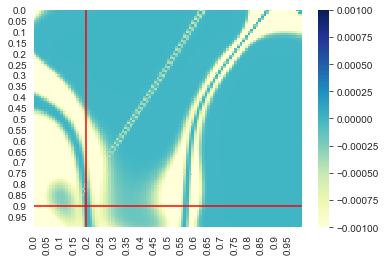

[array([[0.19405387, 0.90285179]]), array([[7.03789732e-29]])]
Optimization restart 1/10, f = 10.637876705481538
Optimization restart 2/10, f = 10.63787670129188
Optimization restart 3/10, f = 10.637876700684636
Optimization restart 4/10, f = 10.637876695239164
Optimization restart 5/10, f = 10.637876696124586
Optimization restart 6/10, f = 74.62837005116002
Optimization restart 7/10, f = 10.63787669747287
Optimization restart 8/10, f = 10.637876698602902
Optimization restart 9/10, f = 10.637876696036408
Optimization restart 10/10, f = 10.638057064561913

Name : gp
Objective : 10.637876695239164
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    17.258312101717436  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.4369246725090196  |      +ve      |       

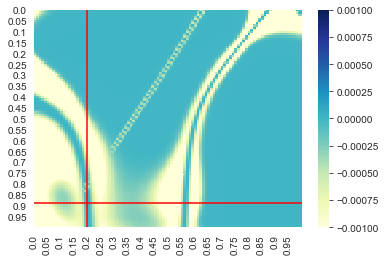

[array([[0.19971724, 0.88750323]]), array([[1.8722902e-25]])]
Optimization restart 1/10, f = 8.97824705313704
Optimization restart 2/10, f = 8.978247054361518
Optimization restart 3/10, f = 8.978247055783143
Optimization restart 4/10, f = 8.978247052582873
Optimization restart 5/10, f = 8.978247050706088
Optimization restart 6/10, f = 8.978247050968989
Optimization restart 7/10, f = 8.978247052163312
Optimization restart 8/10, f = 8.97824705225139
Optimization restart 9/10, f = 8.97824705051589
Optimization restart 10/10, f = 8.978252029849699

Name : gp
Objective : 8.97824705051589
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    17.411670223364844  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.4366463517075453  |      +ve      |        
  Multioutp

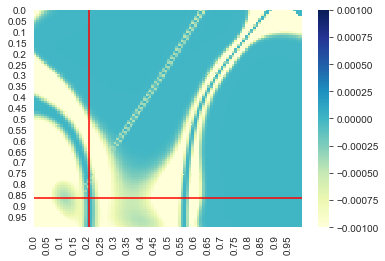

[array([[0.20433632, 0.86738853]]), array([[1.21311841e-20]])]
Optimization restart 1/10, f = 6.623879487276156
Optimization restart 2/10, f = 6.623879487441826
Optimization restart 3/10, f = 6.623879487656012
Optimization restart 4/10, f = 6.623879488290655
Optimization restart 5/10, f = 6.62387949880889
Optimization restart 6/10, f = 6.623879487655458
Optimization restart 7/10, f = 6.6238794861035615
Optimization restart 8/10, f = 6.623879485600995
Optimization restart 9/10, f = 6.62387948561971
Optimization restart 10/10, f = 6.623910703860275

Name : gp
Objective : 6.623879485600995
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    17.400445552850194  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.43674972834867604  |      +ve      |        
  Multi

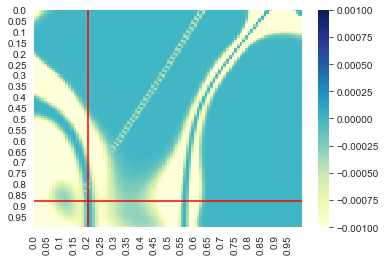

[array([[0.20072387, 0.88164915]]), array([[9.92530384e-25]])]
Optimization restart 1/10, f = 4.527144786041461
Optimization restart 2/10, f = 4.527144785246605
Optimization restart 3/10, f = 4.52714478698357
Optimization restart 4/10, f = 61.91404149259596
Optimization restart 5/10, f = 4.527144787433642
Optimization restart 6/10, f = 4.527144786977587
Optimization restart 7/10, f = 4.527144791766702
Optimization restart 8/10, f = 4.527144788042392
Optimization restart 9/10, f = 4.527144790690315
Optimization restart 10/10, f = 4.527152128308757

Name : gp
Objective : 4.527144785246605
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    17.356743610173513  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.43828885719259797  |      +ve      |        
  Multi

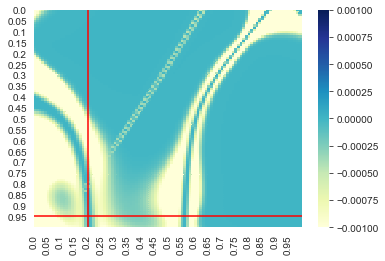

[array([[0.20325532, 0.94766625]]), array([[3.24715965e-77]])]
Optimization restart 1/10, f = 3.5920791246050996
Optimization restart 2/10, f = 3.592079118310359
Optimization restart 3/10, f = 3.5920791174971853
Optimization restart 4/10, f = 3.5920791168132595
Optimization restart 5/10, f = 3.5920791161121244
Optimization restart 6/10, f = 3.592079119377736
Optimization restart 7/10, f = 3.592079119287881
Optimization restart 8/10, f = 3.592079119040825
Optimization restart 9/10, f = 3.5920791168883355
Optimization restart 10/10, f = 3.5920795897961497

Name : gp
Objective : 3.5920791161121244
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    17.305546687918905  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.43674517238154165  |      +ve      |        

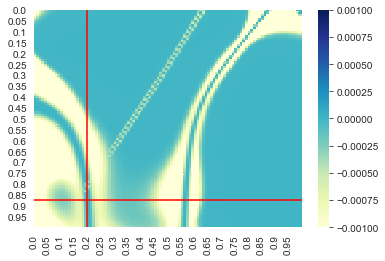

[array([[0.19865831, 0.87702661]]), array([[1.90752891e-19]])]
Optimization restart 1/10, f = 3.7016755485883124
Optimization restart 2/10, f = 3.7016755470431804
Optimization restart 3/10, f = 3.7016755478028784
Optimization restart 4/10, f = 3.7016755479087067
Optimization restart 5/10, f = 3.701675547516615
Optimization restart 6/10, f = 3.7016755481989634
Optimization restart 7/10, f = 3.7016755506377024
Optimization restart 8/10, f = 3.701675548541516
Optimization restart 9/10, f = 3.701675551547524
Optimization restart 10/10, f = 3.7016833814722787

Name : gp
Objective : 3.7016755470431804
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    17.490592049201908  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |       0.4407786458331  |      +ve      |       

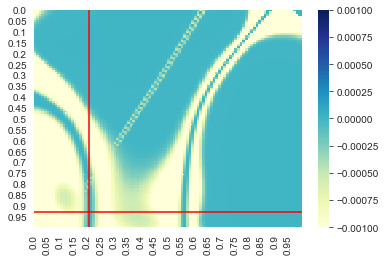

[array([[0.20640068, 0.93056483]]), array([[4.16412013e-62]])]
Optimization restart 1/10, f = 1.195693571963929
Optimization restart 2/10, f = 1.195693571794763
Optimization restart 3/10, f = 1.1956935719730524
Optimization restart 4/10, f = 1.1956935747608242
Optimization restart 5/10, f = 1.1956935712307057
Optimization restart 6/10, f = 1.1956935704699845
Optimization restart 7/10, f = 1.1956935743421155
Optimization restart 8/10, f = 1.1956935729938465
Optimization restart 9/10, f = 1.1956935714954824
Optimization restart 10/10, f = 1.1956936475957889

Name : gp
Objective : 1.1956935704699845
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |      17.40785702009898  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.43999977430602927  |      +ve      |   

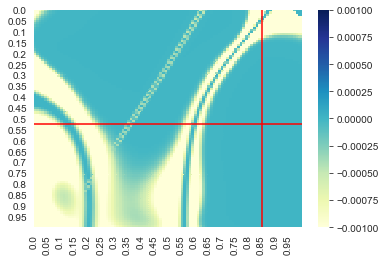

[array([[0.85311731, 0.52324307]]), array([[-0.]])]
Optimization restart 1/10, f = -1.1907645145824048
Optimization restart 2/10, f = -1.1907645127481956
Optimization restart 3/10, f = -1.1907645144623942
Optimization restart 4/10, f = -1.1907645146912955
Optimization restart 5/10, f = -1.1907645148727113
Optimization restart 6/10, f = -1.1907645140278404
Optimization restart 7/10, f = -1.190764514204261
Optimization restart 8/10, f = -1.190764511698191
Optimization restart 9/10, f = -1.1907645140051528
Optimization restart 10/10, f = -1.1906096320211006

Name : gp
Objective : -1.1907645148727113
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     17.53967642044659  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.44163197200337817  |      +ve      |      

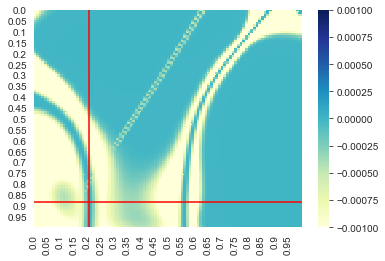

[array([[0.20427846, 0.88222166]]), array([[1.01609429e-28]])]
Optimization restart 1/10, f = -3.313614146456544
Optimization restart 2/10, f = -3.3136141462162954
Optimization restart 3/10, f = 65.92754204482148
Optimization restart 4/10, f = -3.3136141448699163
Optimization restart 5/10, f = -3.313614147163065
Optimization restart 6/10, f = -3.3136141488411823
Optimization restart 7/10, f = -3.313614147654121
Optimization restart 8/10, f = -3.3136141488701014
Optimization restart 9/10, f = -3.3136141502047707
Optimization restart 10/10, f = -3.313581386677626

Name : gp
Objective : -3.3136141502047707
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     17.515348512239864  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.4406647797614024  |      +ve   

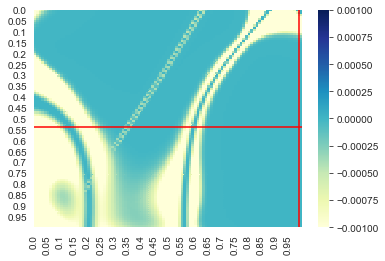

[array([[0.9911038 , 0.53724431]]), array([[-0.]])]
Optimization restart 1/10, f = -5.467114978568439
Optimization restart 2/10, f = -5.467114976574791
Optimization restart 3/10, f = -5.4671149751700625
Optimization restart 4/10, f = -5.467114977364481
Optimization restart 5/10, f = -5.46711497355669
Optimization restart 6/10, f = -5.467114977781563
Optimization restart 7/10, f = -5.467114977416699
Optimization restart 8/10, f = -5.467114977112196
Optimization restart 9/10, f = -5.467114977319639
Optimization restart 10/10, f = -5.467108125707888

Name : gp
Objective : -5.467114978568439
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |      17.33357744079973  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.43612597422733146  |      +ve      |        
  M

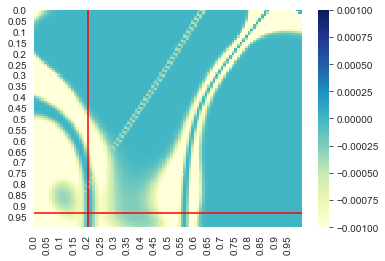

[array([[0.20276421, 0.93318177]]), array([[1.1442063e-63]])]
Optimization restart 1/10, f = -6.890935932417193
Optimization restart 2/10, f = -6.890935931320058
Optimization restart 3/10, f = -6.890935934365515
Optimization restart 4/10, f = -6.890935931941442
Optimization restart 5/10, f = -6.890935932711898
Optimization restart 6/10, f = -6.890935929158047
Optimization restart 7/10, f = -6.890935932582579
Optimization restart 8/10, f = -6.890935930611263
Optimization restart 9/10, f = -6.890935932820838
Optimization restart 10/10, f = -6.8909341894855345

Name : gp
Objective : -6.890935934365515
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     17.211189652373115  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.4356691835310018  |      +ve      | 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/10, f = 37.916349184999795
Optimization restart 2/10, f = 37.91630705345115
Optimization restart 3/10, f = 43.92607047696273
Optimization restart 4/10, f = 27.992995038565123
Optimization restart 5/10, f = 27.992995038121286
Optimization restart 6/10, f = 27.781630669179574
Optimization restart 7/10, f = 28.387978461150823
Optimization restart 8/10, f = 27.78163066803187
Optimization restart 9/10, f = 28.05327112185441
Optimization restart 10/10, f = 27.992920294008428

Name : gp
Objective : 27.78163066803187
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                   value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |        34.1451864719747  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |      0.6690526485466466  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |    

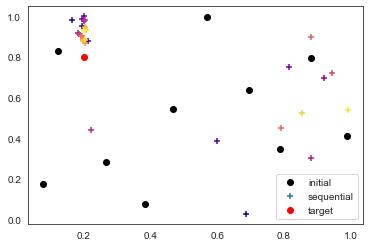

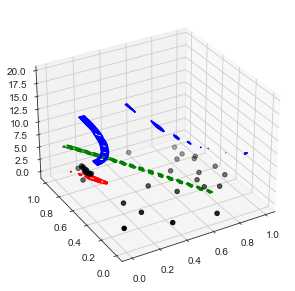

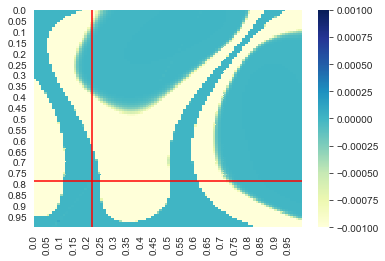

[array([[0.21644899, 0.78877732]]), array([[2.8928833e-47]])]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/10, f = 25.89711307105725
Optimization restart 2/10, f = 25.897113071547373
Optimization restart 3/10, f = 25.897113070669032
Optimization restart 4/10, f = 29.250060369101885
Optimization restart 5/10, f = 26.263102671658515
Optimization restart 6/10, f = 25.89711307161867
Optimization restart 7/10, f = 25.897113071576847
Optimization restart 8/10, f = 25.897113115228187
Optimization restart 9/10, f = 39.83232508639377
Optimization restart 10/10, f = 25.897113071271704

Name : gp
Objective : 25.897113070669032
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                   value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |       69.59010815539476  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |      0.7885360947452206  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |  

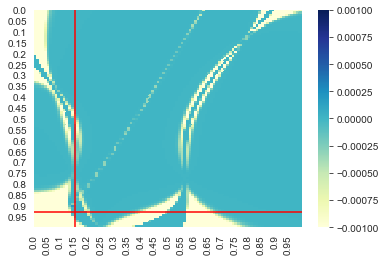

[array([[0.15229417, 0.93222955]]), array([[3.62761783e-59]])]
Optimization restart 1/10, f = 27.522022438335185
Optimization restart 2/10, f = 27.522022436342944
Optimization restart 3/10, f = 29.61251402197169
Optimization restart 4/10, f = 27.52202243590365
Optimization restart 5/10, f = 40.41831018083435
Optimization restart 6/10, f = 29.60760877099802
Optimization restart 7/10, f = 27.52202243644176
Optimization restart 8/10, f = 27.52202243670859
Optimization restart 9/10, f = 27.522022436106774
Optimization restart 10/10, f = 26.55555842112684

Name : gp
Objective : 26.55555842112684
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    32.63253030397552  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.6649171945486541  |      +ve      |        
  Mult

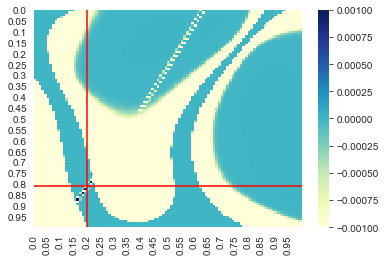

[array([[0.1977013, 0.8087105]]), array([[0.00164214]])]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/10, f = 42.28420706209867
Optimization restart 2/10, f = 25.197228308141117
Optimization restart 3/10, f = 34.72421652821568
Optimization restart 4/10, f = 25.197228311518394
Optimization restart 5/10, f = 42.28420683448536
Optimization restart 6/10, f = 25.197228320705207
Optimization restart 7/10, f = 25.19722830823796
Optimization restart 8/10, f = 25.19722831867139
Optimization restart 9/10, f = 25.197228309079637
Optimization restart 10/10, f = 25.19722831611473

Name : gp
Objective : 25.197228308141117
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |      28.98309239970358  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.6532316665538832  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |      14

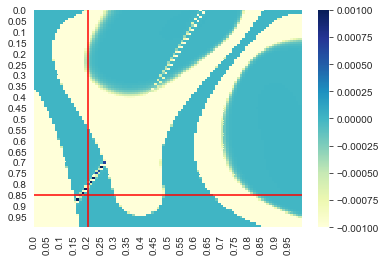

[array([[0.20197705, 0.85172582]]), array([[7.7959519e-25]])]
Optimization restart 1/10, f = 23.223901110298204
Optimization restart 2/10, f = 35.848979516480966
Optimization restart 3/10, f = 23.22390105785091
Optimization restart 4/10, f = 23.22390105955349
Optimization restart 5/10, f = 23.22390106232867
Optimization restart 6/10, f = 23.223901058127062
Optimization restart 7/10, f = 23.223901059536097
Optimization restart 8/10, f = 23.223901073000114
Optimization restart 9/10, f = 23.22390107822032
Optimization restart 10/10, f = 23.22390105818707

Name : gp
Objective : 23.22390105785091
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    31.066075303146118  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6642828042920857  |      +ve      |        
  

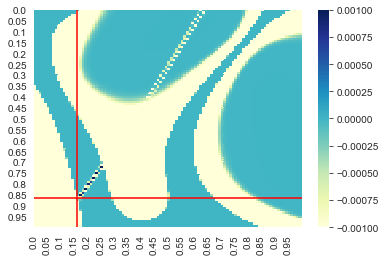

[array([[0.16230829, 0.86548325]]), array([[0.00171198]])]
Optimization restart 1/10, f = 20.532255002558593
Optimization restart 2/10, f = 20.532254992615606
Optimization restart 3/10, f = 20.53225499420997
Optimization restart 4/10, f = 20.53225499210616
Optimization restart 5/10, f = 20.532254997031224
Optimization restart 6/10, f = 20.53225499262984
Optimization restart 7/10, f = 20.532254992615552
Optimization restart 8/10, f = 20.532254997482134
Optimization restart 9/10, f = 20.532254996213016
Optimization restart 10/10, f = 20.534126787830665

Name : gp
Objective : 20.53225499210616
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |      32.72664368785232  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.6739650193656506  |      +ve      |        


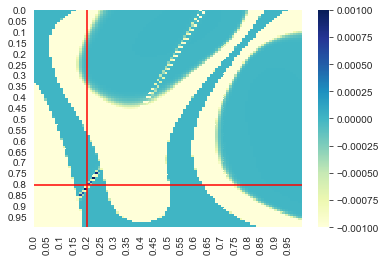

[array([[0.19972425, 0.80380376]]), array([[0.00137721]])]
Optimization restart 1/10, f = 17.674011607537658
Optimization restart 2/10, f = 17.674011610303562
Optimization restart 3/10, f = 17.67401160803293
Optimization restart 4/10, f = 17.674011607734265
Optimization restart 5/10, f = 17.67401161450875
Optimization restart 6/10, f = 17.67401161457872
Optimization restart 7/10, f = 17.674011607225093
Optimization restart 8/10, f = 17.674011607315244
Optimization restart 9/10, f = 17.674011607475393
Optimization restart 10/10, f = 17.67599932984192

Name : gp
Objective : 17.674011607225093
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |      34.03200273884581  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |      0.681080264201727  |      +ve      |        


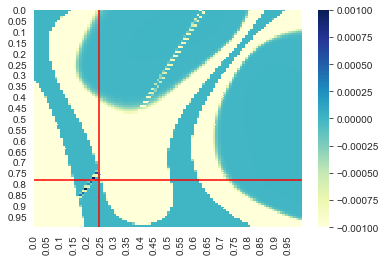

[array([[0.24209233, 0.78213945]]), array([[9.8399084e-29]])]
Optimization restart 1/10, f = 15.138398495637428
Optimization restart 2/10, f = 15.138398494872806
Optimization restart 3/10, f = 15.1383984947695
Optimization restart 4/10, f = 15.13839849499006
Optimization restart 5/10, f = 15.138398496833904
Optimization restart 6/10, f = 15.138398494574997
Optimization restart 7/10, f = 15.138398509806958
Optimization restart 8/10, f = 15.138398495126207
Optimization restart 9/10, f = 15.138398507460277
Optimization restart 10/10, f = 15.139998550481113

Name : gp
Objective : 15.138398494574997
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |      34.44275150711687  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |      0.683284801840468  |      +ve      |     

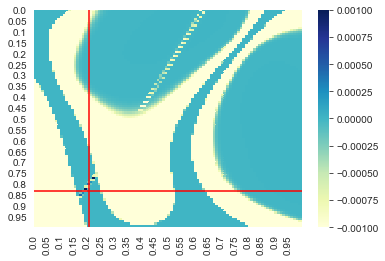

[array([[0.20758325, 0.83281944]]), array([[9.89413541e-23]])]
Optimization restart 1/10, f = 17.460678345827553
Optimization restart 2/10, f = 17.46067833695141
Optimization restart 3/10, f = 17.460678338273723
Optimization restart 4/10, f = 17.46067834351694
Optimization restart 5/10, f = 17.460678336647604
Optimization restart 6/10, f = 17.460678338380596
Optimization restart 7/10, f = 17.460678340839294
Optimization restart 8/10, f = 17.46067833725929
Optimization restart 9/10, f = 17.46067834050455
Optimization restart 10/10, f = 17.460678336877365

Name : gp
Objective : 17.460678336647604
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     34.48891400425158  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6833447141980382  |      +ve      |        

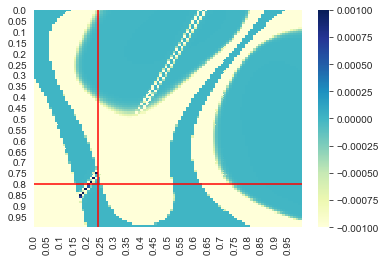

[array([[0.2393465, 0.8017606]]), array([[1.76634267e-20]])]
Optimization restart 1/10, f = 17.198410022344447
Optimization restart 2/10, f = 17.198410072777904
Optimization restart 3/10, f = 17.198410022537722
Optimization restart 4/10, f = 17.198410023102262
Optimization restart 5/10, f = 17.19841002708771
Optimization restart 6/10, f = 17.198410023239155
Optimization restart 7/10, f = 17.19841002602346
Optimization restart 8/10, f = 17.19841002296925
Optimization restart 9/10, f = 17.19841002259522
Optimization restart 10/10, f = 17.257095964580174

Name : gp
Objective : 17.198410022344447
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     35.84650581317537  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.689748361752581  |      +ve      |        
 

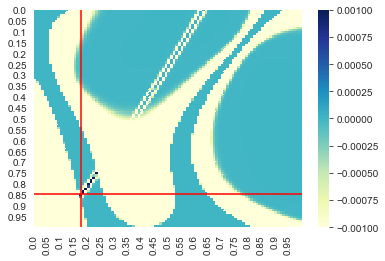

[array([[0.1743569 , 0.84604343]]), array([[0.00411075]])]
Optimization restart 1/10, f = 14.612348524220977
Optimization restart 2/10, f = 14.612348545898264
Optimization restart 3/10, f = 14.612348521536596
Optimization restart 4/10, f = 14.612348522753571
Optimization restart 5/10, f = 14.612348521626366
Optimization restart 6/10, f = 14.612348521523586
Optimization restart 7/10, f = 14.612348533862544
Optimization restart 8/10, f = 14.612348524546348
Optimization restart 9/10, f = 14.61234854202884
Optimization restart 10/10, f = 14.61289609031887

Name : gp
Objective : 14.612348521523586
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    37.024930647087615  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6954297659916887  |      +ve      |        
 

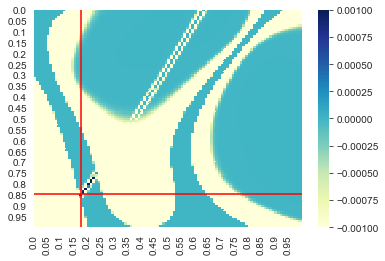

[array([[0.17481334, 0.84520187]]), array([[0.00376266]])]
Optimization restart 1/10, f = 14.51823005532411
Optimization restart 2/10, f = 14.518230043956805
Optimization restart 3/10, f = 14.518230015973202
Optimization restart 4/10, f = 14.518230016193336
Optimization restart 5/10, f = 14.518230015242537
Optimization restart 6/10, f = 46.50893149530451
Optimization restart 7/10, f = 14.518230021746106
Optimization restart 8/10, f = 14.518230017032593
Optimization restart 9/10, f = 14.518230015760004
Optimization restart 10/10, f = 14.524938706018212

Name : gp
Objective : 14.518230015242537
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     37.98029366896807  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6992143062708572  |      +ve      |        
 

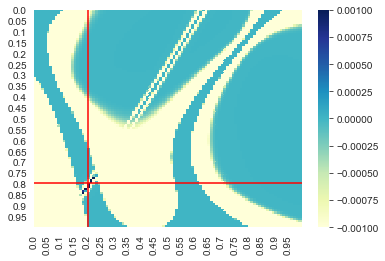

[array([[0.20358072, 0.79776584]]), array([[0.00496601]])]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/10, f = 12.793319234633465
Optimization restart 2/10, f = 12.79331923478614
Optimization restart 3/10, f = 12.7933192414323
Optimization restart 4/10, f = 12.79331923473493
Optimization restart 5/10, f = 38.92245216397751
Optimization restart 6/10, f = 12.793319236565807
Optimization restart 7/10, f = 12.793319260339274
Optimization restart 8/10, f = 12.793319236507273
Optimization restart 9/10, f = 12.793319237991245
Optimization restart 10/10, f = 12.793615741212854

Name : gp
Objective : 12.793319234633465
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    37.028593886355644  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6953369093553621  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |     3096.

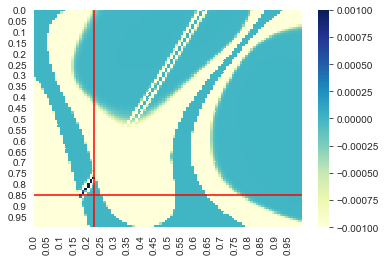

[array([[0.22371234, 0.85064531]]), array([[1.05547328e-21]])]
Optimization restart 1/10, f = 10.34873518133498
Optimization restart 2/10, f = 10.348735181628399
Optimization restart 3/10, f = 10.34873518172217
Optimization restart 4/10, f = 10.348735181560308
Optimization restart 5/10, f = 10.34873518330378
Optimization restart 6/10, f = 10.34873518255295
Optimization restart 7/10, f = 10.348735182877697
Optimization restart 8/10, f = 10.348735183666605
Optimization restart 9/10, f = 10.348735182962656
Optimization restart 10/10, f = 10.348975891394915

Name : gp
Objective : 10.34873518133498
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    37.875663287737574  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6989247651179876  |      +ve      |        


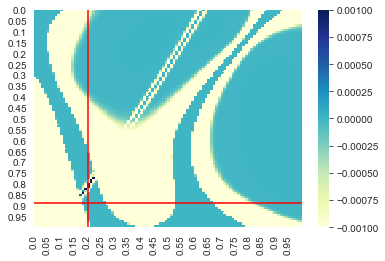

[array([[0.20401576, 0.88998404]]), array([[4.08474284e-25]])]
Optimization restart 1/10, f = 10.21434184036827
Optimization restart 2/10, f = 10.214341823984405
Optimization restart 3/10, f = 10.214341826785876
Optimization restart 4/10, f = 10.214341827361501
Optimization restart 5/10, f = 10.21434182367981
Optimization restart 6/10, f = 10.214341824415435
Optimization restart 7/10, f = 10.21434182810988
Optimization restart 8/10, f = 10.214341837825927
Optimization restart 9/10, f = 10.214341823622185
Optimization restart 10/10, f = 10.214821361260299

Name : gp
Objective : 10.214341823622185
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     38.14212980744959  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6991398962220445  |      +ve      |       

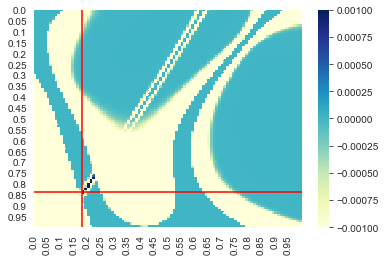

[array([[0.17967961, 0.83728727]]), array([[0.00537489]])]
Optimization restart 1/10, f = 7.908758286895733
Optimization restart 2/10, f = 7.90875827794374
Optimization restart 3/10, f = 7.908758274519897
Optimization restart 4/10, f = 7.908758271889035
Optimization restart 5/10, f = 53.89368614323391
Optimization restart 6/10, f = 7.908758272890225
Optimization restart 7/10, f = 7.908758272767301
Optimization restart 8/10, f = 7.90875827399806
Optimization restart 9/10, f = 7.908758274445823
Optimization restart 10/10, f = 7.908957351526617

Name : gp
Objective : 7.908758271889035
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     38.13268724412786  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6983218055696614  |      +ve      |        
  Multioutpu

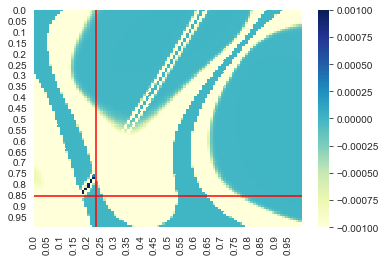

[array([[0.23098638, 0.85582666]]), array([[5.11402146e-29]])]
Optimization restart 1/10, f = 5.996692952210665
Optimization restart 2/10, f = 5.996692964385417
Optimization restart 3/10, f = 5.996692954482839
Optimization restart 4/10, f = 5.9966929521757635
Optimization restart 5/10, f = 5.996692952865374
Optimization restart 6/10, f = 5.996692954571728
Optimization restart 7/10, f = 5.996692953051706
Optimization restart 8/10, f = 5.996692952762501
Optimization restart 9/10, f = 5.996692952397694
Optimization restart 10/10, f = 5.996832265489772

Name : gp
Objective : 5.9966929521757635
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     37.25832264090052  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6942680004726111  |      +ve      |        
  Mu

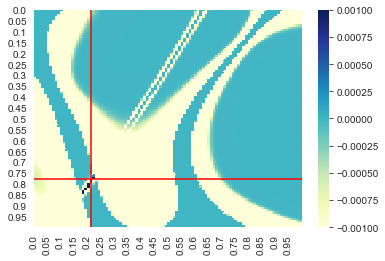

[array([[0.21444531, 0.77806474]]), array([[0.00485894]])]
Optimization restart 1/10, f = 4.342774788993175
Optimization restart 2/10, f = 4.342774789772342
Optimization restart 3/10, f = 4.34277478906861
Optimization restart 4/10, f = 4.342774789608242
Optimization restart 5/10, f = 4.342774788940915
Optimization restart 6/10, f = 4.342774790862197
Optimization restart 7/10, f = 4.342774788058783
Optimization restart 8/10, f = 4.342774792900279
Optimization restart 9/10, f = 4.342774788918341
Optimization restart 10/10, f = 4.343188721890442

Name : gp
Objective : 4.342774788058783
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     37.36529656963176  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6963024807267084  |      +ve      |        
  Multioutp

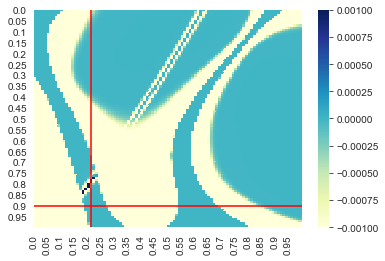

[array([[0.21456555, 0.90382857]]), array([[3.3630642e-43]])]
Optimization restart 1/10, f = 3.204114305143392
Optimization restart 2/10, f = 3.2041142985547566
Optimization restart 3/10, f = 3.2041142993122946
Optimization restart 4/10, f = 3.2041142989562985
Optimization restart 5/10, f = 3.2041142991505893
Optimization restart 6/10, f = 3.204114299325198
Optimization restart 7/10, f = 3.204114299573419
Optimization restart 8/10, f = 3.2041142993494276
Optimization restart 9/10, f = 3.2041142992013363
Optimization restart 10/10, f = 3.204353380324605

Name : gp
Objective : 3.2041142985547566
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     37.96000197324276  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6987304204857775  |      +ve      |        


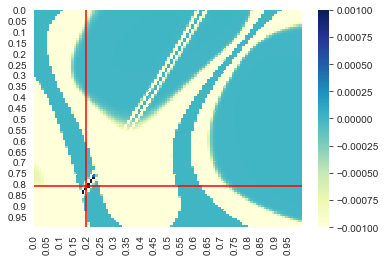

[array([[0.19529109, 0.81024478]]), array([[0.00498035]])]
Optimization restart 1/10, f = 2.229398684458218
Optimization restart 2/10, f = 2.229398684208576
Optimization restart 3/10, f = 2.229398684372235
Optimization restart 4/10, f = 2.2293986907479493
Optimization restart 5/10, f = 2.2293986840529527
Optimization restart 6/10, f = 2.2293986844501603
Optimization restart 7/10, f = 2.2293986845396105
Optimization restart 8/10, f = 2.2293986841737627
Optimization restart 9/10, f = 2.2293986843835754
Optimization restart 10/10, f = 2.229855342025587

Name : gp
Objective : 2.2293986840529527
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |      36.71459160051251  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.6934819745594956  |      +ve      |        


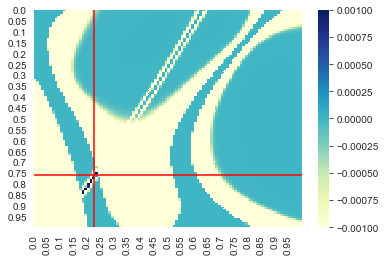

[array([[0.22538185, 0.7593271 ]]), array([[0.00484011]])]
Optimization restart 1/10, f = 0.06797673676042493
Optimization restart 2/10, f = 0.0679767402960536
Optimization restart 3/10, f = 0.06797673678818938
Optimization restart 4/10, f = 0.06797673647091784
Optimization restart 5/10, f = 0.06797673703102092
Optimization restart 6/10, f = 0.0679767366593147
Optimization restart 7/10, f = 0.06797673705061769
Optimization restart 8/10, f = 0.06797673657519354
Optimization restart 9/10, f = 0.06797673645052171
Optimization restart 10/10, f = 0.06908775202959916

Name : gp
Objective : 0.06797673645052171
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     36.45853958461243  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6920329572432549  |      +ve      

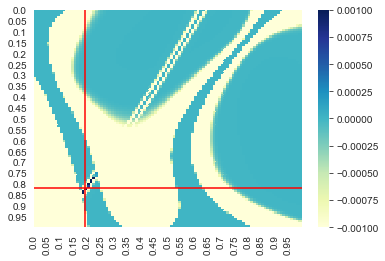

[array([[0.1897682 , 0.81964053]]), array([[0.00452172]])]
Optimization restart 1/10, f = 0.13646979960637395
Optimization restart 2/10, f = 0.13646979968729056
Optimization restart 3/10, f = 0.13646979995894526
Optimization restart 4/10, f = 0.13646979979466778
Optimization restart 5/10, f = 0.13646979954484095
Optimization restart 6/10, f = 0.1364697999823079
Optimization restart 7/10, f = 0.13646980565627587
Optimization restart 8/10, f = 0.13646980015887777
Optimization restart 9/10, f = 0.1364697999021871
Optimization restart 10/10, f = 0.14772118543649526

Name : gp
Objective : 0.13646979954484095
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    36.790425896044795  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6929562533940296  |      +ve      

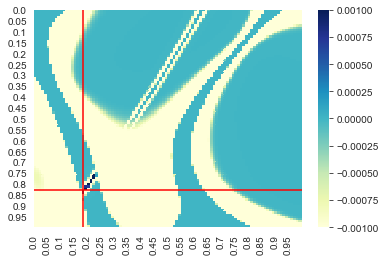

[array([[0.18248477, 0.83087536]]), array([[0.00545791]])]
Optimization restart 1/10, f = -1.6454243406303561
Optimization restart 2/10, f = -1.6454243412334506
Optimization restart 3/10, f = -1.6454243413399894
Optimization restart 4/10, f = -1.6454243411974403
Optimization restart 5/10, f = -1.6454243410151719
Optimization restart 6/10, f = -1.6454243409912408
Optimization restart 7/10, f = -1.6454243390357135
Optimization restart 8/10, f = -1.6454243409978915
Optimization restart 9/10, f = -1.6454243394084926
Optimization restart 10/10, f = -1.6454107013734642

Name : gp
Objective : -1.6454243413399894
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |      37.23852648558599  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.6962818327660224  |      +ve 

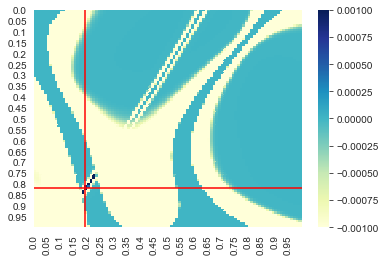

[array([[0.18934017, 0.81915214]]), array([[0.0053269]])]
Optimization restart 1/10, f = -3.333261329263067
Optimization restart 2/10, f = -3.333261328734224
Optimization restart 3/10, f = -3.3332613277274845
Optimization restart 4/10, f = -3.3332613290345847
Optimization restart 5/10, f = -3.3332613283874224
Optimization restart 6/10, f = -3.333261327763509
Optimization restart 7/10, f = -3.3332613284224664
Optimization restart 8/10, f = -3.3332613281728953
Optimization restart 9/10, f = -3.333261328923726
Optimization restart 10/10, f = -3.333206789569388

Name : gp
Objective : -3.333261329263067
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |      37.61767983190653  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.6981845956212042  |      +ve      | 

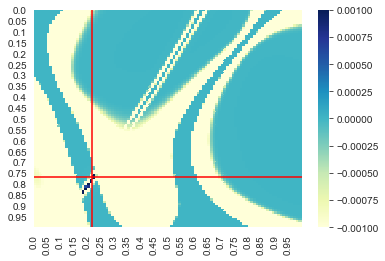

[array([[0.21776297, 0.76927391]]), array([[0.00495108]])]
Optimization restart 1/10, f = -4.552427566214099
Optimization restart 2/10, f = -4.552427563736735
Optimization restart 3/10, f = -4.552427567092913
Optimization restart 4/10, f = -4.5524275622641355
Optimization restart 5/10, f = -4.5524275667060365
Optimization restart 6/10, f = -4.552427567080294
Optimization restart 7/10, f = -4.552427566191362
Optimization restart 8/10, f = -4.552427567338519
Optimization restart 9/10, f = -4.552427567168657
Optimization restart 10/10, f = -4.551982072514228

Name : gp
Objective : -4.552427567338519
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     37.61975633211042  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6991540210161237  |      +ve      |      

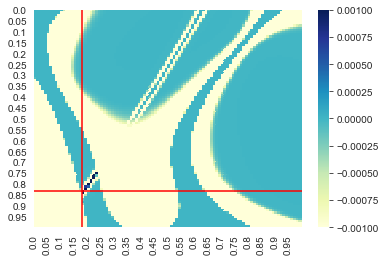

[array([[0.18077577, 0.83381382]]), array([[0.00530824]])]
Optimization restart 1/10, f = 52.62034603555752
Optimization restart 2/10, f = -6.567319313340292
Optimization restart 3/10, f = -6.567319313772458
Optimization restart 4/10, f = -6.5673193099812295
Optimization restart 5/10, f = -6.567319301032597
Optimization restart 6/10, f = -6.567319314439473
Optimization restart 7/10, f = -6.56731931370652
Optimization restart 8/10, f = -6.567319312927239
Optimization restart 9/10, f = -6.567319314765385
Optimization restart 10/10, f = -6.567306106063754

Name : gp
Objective : -6.567319314765385
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     37.63482734672651  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6985607185670437  |      +ve      |        


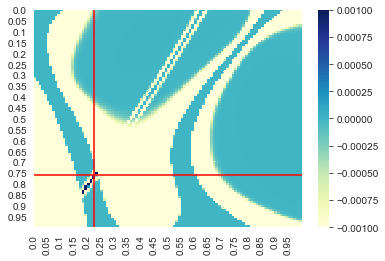

[array([[0.22349457, 0.75806305]]), array([[0.00438197]])]
Optimization restart 1/10, f = -8.357390802636942
Optimization restart 2/10, f = -8.357390801816692
Optimization restart 3/10, f = -8.357390801458564
Optimization restart 4/10, f = -8.357390799049242
Optimization restart 5/10, f = -8.357390801992281
Optimization restart 6/10, f = -8.35739080152321
Optimization restart 7/10, f = -8.35739080115924
Optimization restart 8/10, f = -8.357390798378248
Optimization restart 9/10, f = -8.357390802424007
Optimization restart 10/10, f = -8.357376148034248

Name : gp
Objective : -8.357390802636942
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     37.80581403646166  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6997540504876171  |      +ve      |        
 

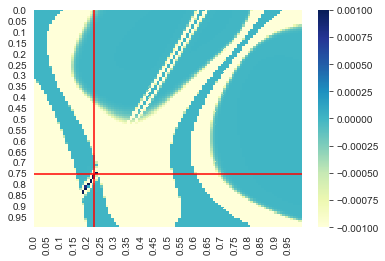

[array([[0.22627824, 0.75642593]]), array([[0.00513934]])]
Optimization restart 1/10, f = -8.789922715469288
Optimization restart 2/10, f = -8.789922711551725
Optimization restart 3/10, f = -8.789922716428237
Optimization restart 4/10, f = -8.789922713614544
Optimization restart 5/10, f = -8.789922716295692
Optimization restart 6/10, f = -8.78992271564158
Optimization restart 7/10, f = -8.789922715196923
Optimization restart 8/10, f = 50.57584172704344
Optimization restart 9/10, f = -8.78992271565069
Optimization restart 10/10, f = -8.785061304452697

Name : gp
Objective : -8.789922716428237
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     37.17817034709889  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6970781365827824  |      +ve      |        
  

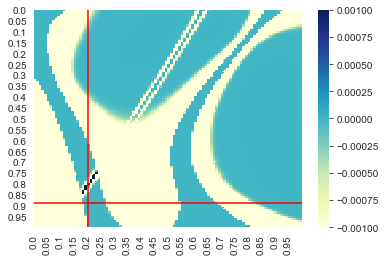

[array([[0.20054601, 0.887308  ]]), array([[3.03927894e-19]])]
Optimization restart 1/10, f = -10.484697884761331
Optimization restart 2/10, f = -10.48469790940436
Optimization restart 3/10, f = -10.484697909977939
Optimization restart 4/10, f = -10.4846979068491
Optimization restart 5/10, f = -10.48469790960798
Optimization restart 6/10, f = -10.48469786449484
Optimization restart 7/10, f = -10.484697908971441
Optimization restart 8/10, f = -10.484697910237486
Optimization restart 9/10, f = -10.484697905639287
Optimization restart 10/10, f = -10.484683463305053

Name : gp
Objective : -10.484697910237486
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     37.35145863084162  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6991527084440419  |      +ve     

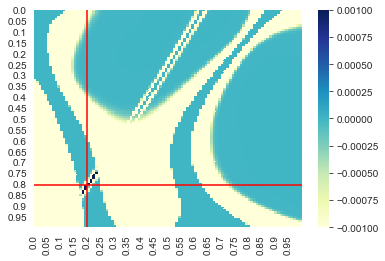

[array([[0.19682087, 0.80603296]]), array([[0.00513359]])]
Optimization restart 1/10, f = -10.292539690193138
Optimization restart 2/10, f = -10.29253969341606
Optimization restart 3/10, f = -10.292539690723032
Optimization restart 4/10, f = -10.29253969455793
Optimization restart 5/10, f = -10.29253969481016
Optimization restart 6/10, f = -10.292539694237973
Optimization restart 7/10, f = -10.292539694318833
Optimization restart 8/10, f = -10.292539693253843
Optimization restart 9/10, f = -10.292539693894128
Optimization restart 10/10, f = -10.292528508677648

Name : gp
Objective : -10.29253969481016
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     37.20563531813687  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6981796654171655  |      +ve      | 

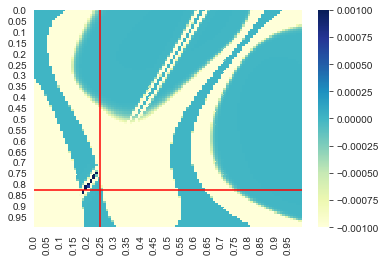

[array([[0.24636978, 0.83008773]]), array([[4.37020849e-27]])]
Optimization restart 1/10, f = -11.6311686932209
Optimization restart 2/10, f = -11.631168692853038
Optimization restart 3/10, f = -11.631168692930814
Optimization restart 4/10, f = -11.631168693366632
Optimization restart 5/10, f = -11.63116869113638
Optimization restart 6/10, f = -11.631168693947984
Optimization restart 7/10, f = -11.631168690216242
Optimization restart 8/10, f = -11.631168693597331
Optimization restart 9/10, f = -11.63116869249231
Optimization restart 10/10, f = -11.630822225095585

Name : gp
Objective : -11.631168693947984
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    36.638890127849436  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.6952371616317039  |      +ve    

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 31.17663472118365
Optimization restart 2/10, f = 31.1766347211629
Optimization restart 3/10, f = 53.80446419496433
Optimization restart 4/10, f = 32.66426902696247
Optimization restart 5/10, f = 31.17663472168826
Optimization restart 6/10, f = 52.329989478713095
Optimization restart 7/10, f = 43.15558037251029
Optimization restart 8/10, f = 31.887841832783415
Optimization restart 9/10, f = 31.176634721138644
Optimization restart 10/10, f = 31.176634721317953

Name : gp
Objective : 31.176634721138644
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    16.191703735776443  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     1.595201849041581  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |     4773.19

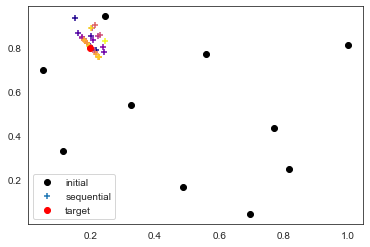

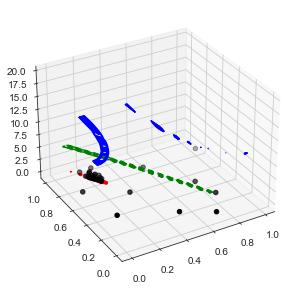

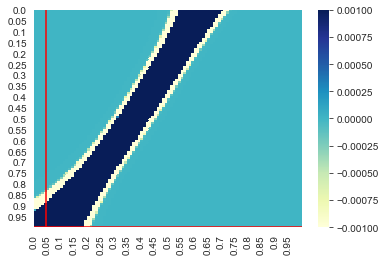

[array([[0.04627712, 1.        ]]), array([[3.55813218]])]
Optimization restart 1/10, f = 31.860852395767775
Optimization restart 2/10, f = 31.860852391585837
Optimization restart 3/10, f = 29.877584857792193
Optimization restart 4/10, f = 31.860852393719977
Optimization restart 5/10, f = 31.471894373584757
Optimization restart 6/10, f = 30.53682045070522
Optimization restart 7/10, f = 31.86085239174341
Optimization restart 8/10, f = 31.823456723954394
Optimization restart 9/10, f = 29.87758485791705
Optimization restart 10/10, f = 29.87938935136261

Name : gp
Objective : 29.877584857792193
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                   value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |       25.92488789059842  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |      0.6294726186257877  |      +ve      |      

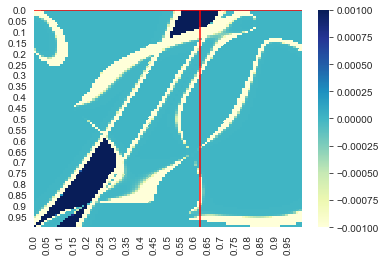

[array([[0.62211126, 0.        ]]), array([[2.20877836]])]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 63.5034682820408
Optimization restart 2/10, f = 63.75420827432977
Optimization restart 3/10, f = 62.54924618884372
Optimization restart 4/10, f = 33.873308321054935
Optimization restart 5/10, f = 33.873308321749995
Optimization restart 6/10, f = 33.873308321759254
Optimization restart 7/10, f = 33.87330835561491
Optimization restart 8/10, f = 33.87330832229518
Optimization restart 9/10, f = 33.87330832957197
Optimization restart 10/10, f = 33.87341363793638

Name : gp
Objective : 33.873308321054935
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     39.301152140112904  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.7341624761657504  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |      4515

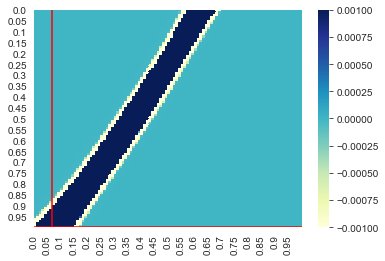

[array([[0.06875664, 1.        ]]), array([[1.25687278]])]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 38.42449729526628
Optimization restart 2/10, f = 38.78067638138786
Optimization restart 3/10, f = 38.78067638078168
Optimization restart 4/10, f = 66.90156952018592
Optimization restart 5/10, f = 43.311999830657356
Optimization restart 6/10, f = 38.42449729303662
Optimization restart 7/10, f = 66.54612489506154
Optimization restart 8/10, f = 38.424497298920876
Optimization restart 9/10, f = 66.89863060888831
Optimization restart 10/10, f = 38.43960508359193

Name : gp
Objective : 38.42449729303662
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    41.06219117655421  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.736681326593925  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |    5620.94025487

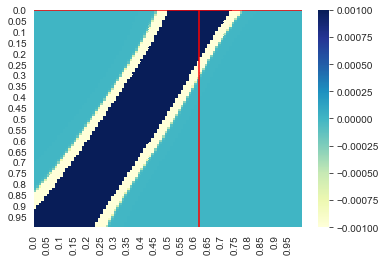

[array([[0.61712102, 0.        ]]), array([[5.32327586]])]
Optimization restart 1/10, f = 39.02974578494991
Optimization restart 2/10, f = 37.26628200128947
Optimization restart 3/10, f = 37.266282000819
Optimization restart 4/10, f = 37.26628199957429
Optimization restart 5/10, f = 39.029745777960585
Optimization restart 6/10, f = 39.02974578750829
Optimization restart 7/10, f = 37.26628200345697
Optimization restart 8/10, f = 41.01322877937082
Optimization restart 9/10, f = 37.26628200350539
Optimization restart 10/10, f = 39.030111799103096

Name : gp
Objective : 37.26628199957429
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     22.995634111358584  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.4549198413317316  |      +ve      |        
  Multi

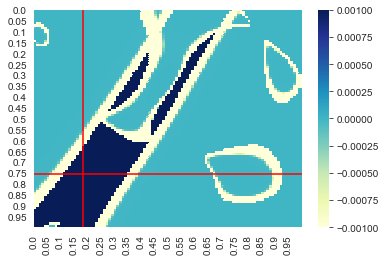

[array([[0.18355224, 0.75602347]]), array([[3.39346918]])]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 69.1654851082565
Optimization restart 2/10, f = 36.61554847897379
Optimization restart 3/10, f = 48.120911511876535
Optimization restart 4/10, f = 45.606064031910556
Optimization restart 5/10, f = 70.91763424807762
Optimization restart 6/10, f = 36.61554846187866
Optimization restart 7/10, f = 36.6155484696411
Optimization restart 8/10, f = 36.615548461630155
Optimization restart 9/10, f = 49.17321236860396
Optimization restart 10/10, f = 36.615561273434196

Name : gp
Objective : 36.615548461630155
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     22.478199114035018  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.44759863098802827  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |      5496

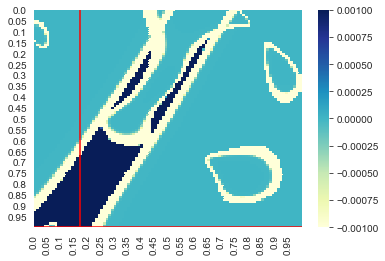

[array([[0.17329952, 1.        ]]), array([[1.83590143]])]
Optimization restart 1/10, f = 35.2838459059936
Optimization restart 2/10, f = 35.283845887870996
Optimization restart 3/10, f = 35.28384588129464
Optimization restart 4/10, f = 39.00827208787977
Optimization restart 5/10, f = 62.1351378388308
Optimization restart 6/10, f = 72.88270619656588
Optimization restart 7/10, f = 35.28384588133477
Optimization restart 8/10, f = 72.88257823292591
Optimization restart 9/10, f = 35.28384588271198
Optimization restart 10/10, f = 35.28388033083874

Name : gp
Objective : 35.28384588129464
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     23.137679881771774  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.4443634866551791  |      +ve      |        
  Multio

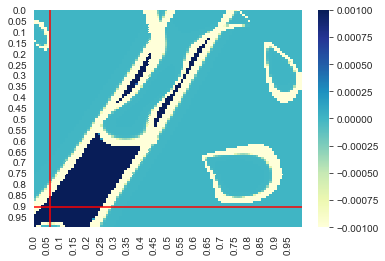

[array([[0.05968319, 0.90664868]]), array([[1.53212568]])]
Optimization restart 1/10, f = 33.44438857024723
Optimization restart 2/10, f = 33.44438856412641
Optimization restart 3/10, f = 43.57207593415447
Optimization restart 4/10, f = 33.444388565537494
Optimization restart 5/10, f = 77.2328176097946
Optimization restart 6/10, f = 74.52948259139113
Optimization restart 7/10, f = 42.3404156952825
Optimization restart 8/10, f = 33.44438856613344
Optimization restart 9/10, f = 33.444388567311734
Optimization restart 10/10, f = 33.44441332782975

Name : gp
Objective : 33.44438856412641
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     26.361907883251117  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.4669599379169011  |      +ve      |        
  Multi

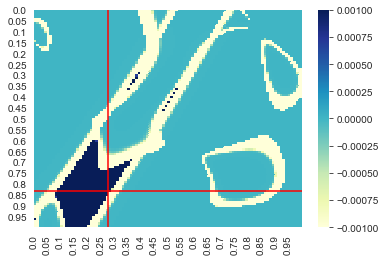

[array([[0.27528163, 0.83322342]]), array([[0.24009588]])]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 34.01253543461367
Optimization restart 2/10, f = 34.012535434905345
Optimization restart 3/10, f = 34.012535453993834
Optimization restart 4/10, f = 73.63392825680084
Optimization restart 5/10, f = 86.55373320452598
Optimization restart 6/10, f = 34.01253543442667
Optimization restart 7/10, f = 78.49505436030057
Optimization restart 8/10, f = 78.46764119911197
Optimization restart 9/10, f = 34.01253599589995
Optimization restart 10/10, f = 34.01255873471253

Name : gp
Objective : 34.01253543442667
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     24.913898794002822  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.4350092566108398  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |      5654.

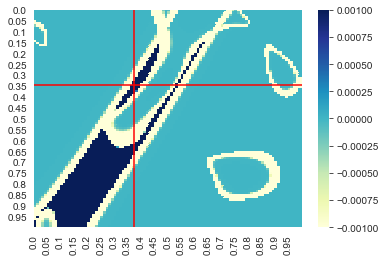

[array([[0.37584914, 0.34469691]]), array([[0.81260216]])]
Optimization restart 1/10, f = 80.31235517575502
Optimization restart 2/10, f = 32.34957028808296
Optimization restart 3/10, f = 32.34957032021016
Optimization restart 4/10, f = 82.02773272843476
Optimization restart 5/10, f = 32.34957028560497
Optimization restart 6/10, f = 32.34957030278709
Optimization restart 7/10, f = 32.349570279914346
Optimization restart 8/10, f = 32.34957044166124
Optimization restart 9/10, f = 32.34957028784491
Optimization restart 10/10, f = 32.349760779570396

Name : gp
Objective : 32.349570279914346
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     26.64223917457744  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.44830427321444316  |      +ve      |        
  Multi

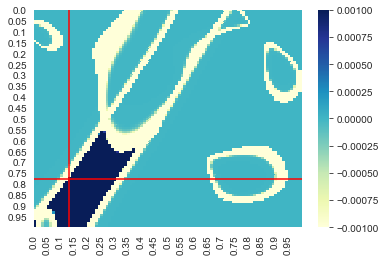

[array([[0.1321468, 0.7771576]]), array([[0.34687907]])]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 29.91481291315791
Optimization restart 2/10, f = 70.46573782071582
Optimization restart 3/10, f = 45.588204173451516
Optimization restart 4/10, f = 41.22784944430158
Optimization restart 5/10, f = 29.914812953768404
Optimization restart 6/10, f = 43.62868557657812
Optimization restart 7/10, f = 39.30221004378364
Optimization restart 8/10, f = 29.91481291321064
Optimization restart 9/10, f = 29.914812921829196
Optimization restart 10/10, f = 29.914842498221823

Name : gp
Objective : 29.91481291315791
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |       27.4899309711795  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.4549902613386202  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |      585

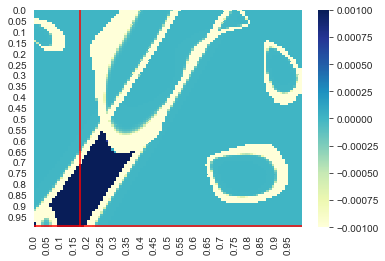

[array([[0.17288019, 0.9960125 ]]), array([[0.2512077]])]
Optimization restart 1/10, f = 28.435558716535244
Optimization restart 2/10, f = 28.435558708771126
Optimization restart 3/10, f = 28.435558706845807
Optimization restart 4/10, f = 28.435558706285303
Optimization restart 5/10, f = 28.4355587082342
Optimization restart 6/10, f = 28.4355587069365
Optimization restart 7/10, f = 28.435558728615717
Optimization restart 8/10, f = 28.43555873078765
Optimization restart 9/10, f = 28.43555872078575
Optimization restart 10/10, f = 28.435575587202173

Name : gp
Objective : 28.435558706285303
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    28.852204663779204  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.47318405733447905  |      +ve      |        
  Mult

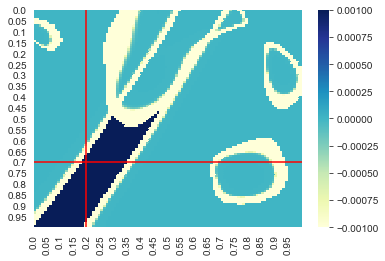

[array([[0.19358151, 0.70236703]]), array([[0.46833109]])]
Optimization restart 1/10, f = 29.509590698895366
Optimization restart 2/10, f = 29.50959071452575
Optimization restart 3/10, f = 29.50959067984887
Optimization restart 4/10, f = 29.50959067448546
Optimization restart 5/10, f = 29.509590671433095
Optimization restart 6/10, f = 77.06529702446332
Optimization restart 7/10, f = 29.509590673497634
Optimization restart 8/10, f = 29.50959066936145
Optimization restart 9/10, f = 29.509590670525952
Optimization restart 10/10, f = 29.509598630277203

Name : gp
Objective : 29.50959066936145
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |      30.4205872535271  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.5103387900558296  |      +ve      |        
  Mul

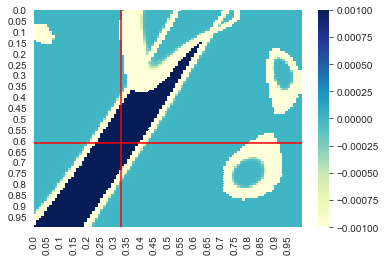

[array([[0.32466794, 0.61164044]]), array([[1.65699141]])]
Optimization restart 1/10, f = 27.63017471708631
Optimization restart 2/10, f = 27.63017471811085
Optimization restart 3/10, f = 27.630174715366696
Optimization restart 4/10, f = 27.630174715882024
Optimization restart 5/10, f = 27.630174720978594
Optimization restart 6/10, f = 27.630174717922678
Optimization restart 7/10, f = 27.630174719860616
Optimization restart 8/10, f = 27.63017471539963
Optimization restart 9/10, f = 27.63017471916992
Optimization restart 10/10, f = 27.630178345429734

Name : gp
Objective : 27.630174715366696
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    29.891340855279818  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.5032436711127605  |      +ve      |        
  M

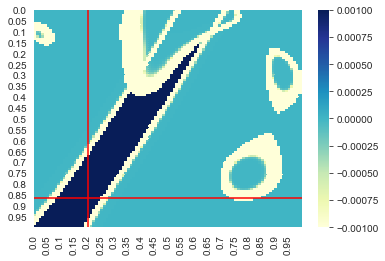

[array([[0.20058367, 0.86525574]]), array([[1.29803965]])]
Optimization restart 1/10, f = 25.590384415580147
Optimization restart 2/10, f = 90.22142925837417
Optimization restart 3/10, f = 25.59038440818275
Optimization restart 4/10, f = 25.590384408809328
Optimization restart 5/10, f = 25.590384408354076
Optimization restart 6/10, f = 25.59038441010174
Optimization restart 7/10, f = 25.590384411369087
Optimization restart 8/10, f = 25.59038440751558
Optimization restart 9/10, f = 25.590384411252764
Optimization restart 10/10, f = 25.59038617780113

Name : gp
Objective : 25.59038440751558
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    30.269102537636456  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.5036024358251835  |      +ve      |        
  Mul

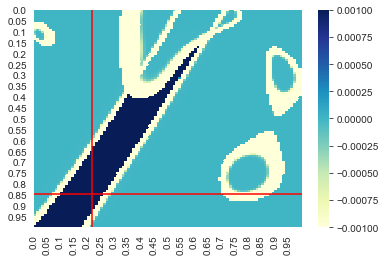

[array([[0.21647548, 0.84900067]]), array([[1.09279671]])]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 25.215418122731307
Optimization restart 2/10, f = 57.082557085384515
Optimization restart 3/10, f = 25.215418126995885
Optimization restart 4/10, f = 25.21541812311804
Optimization restart 5/10, f = 25.21541813416718
Optimization restart 6/10, f = 58.1820368804183
Optimization restart 7/10, f = 25.215418160875195
Optimization restart 8/10, f = 25.215418124319406
Optimization restart 9/10, f = 25.21541812682417
Optimization restart 10/10, f = 25.215423541521062

Name : gp
Objective : 25.215418122731307
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |      29.5786580650455  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.49639164422775356  |      +ve      |        
  MultioutputDerivativeKern.rbf_1.variance          |     5876.

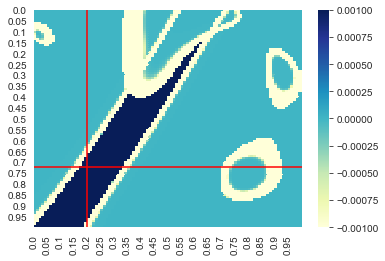

[array([[0.19706935, 0.72455136]]), array([[1.14747041]])]
Optimization restart 1/10, f = 23.39794506543926
Optimization restart 2/10, f = 23.39794505673573
Optimization restart 3/10, f = 23.397945053279386
Optimization restart 4/10, f = 23.39794505546871
Optimization restart 5/10, f = 23.397945053608687
Optimization restart 6/10, f = 23.397945121150762
Optimization restart 7/10, f = 23.397945056747254
Optimization restart 8/10, f = 23.397945063848738
Optimization restart 9/10, f = 23.39794505396987
Optimization restart 10/10, f = 23.397960321692096

Name : gp
Objective : 23.397945053279386
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     29.52610672261098  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.4970935558873904  |      +ve      |        
  M

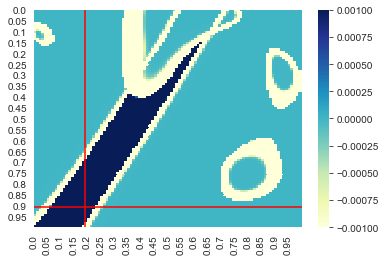

[array([[0.18982496, 0.90591972]]), array([[1.12839629]])]
Optimization restart 1/10, f = 24.686350254490122
Optimization restart 2/10, f = 24.686350254591858
Optimization restart 3/10, f = 24.68635026724416
Optimization restart 4/10, f = 24.686350255597773
Optimization restart 5/10, f = 24.68635025966529
Optimization restart 6/10, f = 24.686350255392313
Optimization restart 7/10, f = 63.193944488672656
Optimization restart 8/10, f = 24.68635026373053
Optimization restart 9/10, f = 24.686350258988426
Optimization restart 10/10, f = 24.68636348747505

Name : gp
Objective : 24.686350254490122
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    29.621554830276224  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.49581856454446815  |      +ve      |        
  M

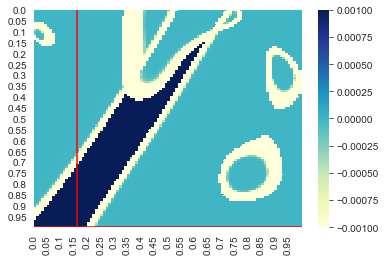

[array([[0.15964488, 1.        ]]), array([[1.13046612]])]
Optimization restart 1/10, f = 22.74746760582218
Optimization restart 2/10, f = 22.74746760353765
Optimization restart 3/10, f = 22.747467608780077
Optimization restart 4/10, f = 22.74746762401604
Optimization restart 5/10, f = 22.747467604317947
Optimization restart 6/10, f = 22.74746765267389
Optimization restart 7/10, f = 22.747467603884644
Optimization restart 8/10, f = 22.74746762931681
Optimization restart 9/10, f = 22.74746760549384
Optimization restart 10/10, f = 22.747499335968733

Name : gp
Objective : 22.74746760353765
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    29.737802408650644  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.49615525094001695  |      +ve      |        
  Mult

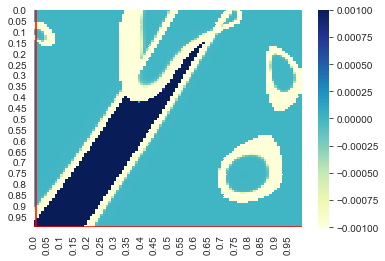

[array([[0.00866611, 1.        ]]), array([[1.33189797]])]
Optimization restart 1/10, f = 21.43566789427804
Optimization restart 2/10, f = 21.43566789460096
Optimization restart 3/10, f = 21.435667902210866
Optimization restart 4/10, f = 21.435667895563114
Optimization restart 5/10, f = 21.435667894904263
Optimization restart 6/10, f = 21.43566789435905
Optimization restart 7/10, f = 21.43566789482731
Optimization restart 8/10, f = 21.435667896288102
Optimization restart 9/10, f = 21.435667901750904
Optimization restart 10/10, f = 21.43624097605103

Name : gp
Objective : 21.43566789427804
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     27.507730506801156  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.4834173267916041  |      +ve      |        
  

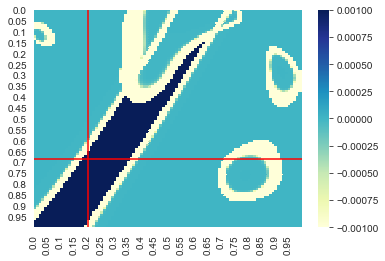

[array([[0.20366808, 0.68558686]]), array([[0.9594214]])]
Optimization restart 1/10, f = 19.371853956528987
Optimization restart 2/10, f = 19.371853957292423
Optimization restart 3/10, f = 19.371853956044184
Optimization restart 4/10, f = 19.371853959001037
Optimization restart 5/10, f = 19.371853955319402
Optimization restart 6/10, f = 19.371853956240948
Optimization restart 7/10, f = 19.371853957372657
Optimization restart 8/10, f = 19.371853956130543
Optimization restart 9/10, f = 19.37185395635884
Optimization restart 10/10, f = 19.3718840871826

Name : gp
Objective : 19.371853955319402
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     27.87396351137671  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.4842703315343768  |      +ve      |        
  M

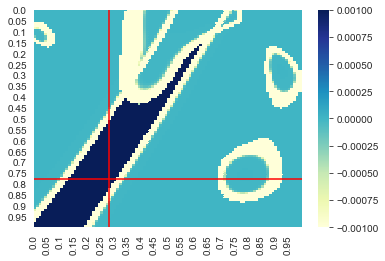

[array([[0.2803167, 0.7786674]]), array([[0.8856101]])]
Optimization restart 1/10, f = 17.69926445190046
Optimization restart 2/10, f = 17.699264453675724
Optimization restart 3/10, f = 17.699264447573526
Optimization restart 4/10, f = 73.26304867815506
Optimization restart 5/10, f = 17.699264446917113
Optimization restart 6/10, f = 17.699264453169093
Optimization restart 7/10, f = 17.699264449120605
Optimization restart 8/10, f = 17.699264448148114
Optimization restart 9/10, f = 17.69926445678732
Optimization restart 10/10, f = 17.699273821481043

Name : gp
Objective : 17.699264446917113
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    27.789734431624034  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.4881515440233404  |      +ve      |        
  Mul

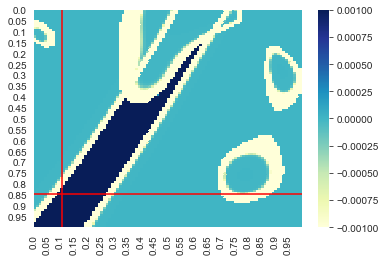

[array([[0.10677496, 0.84538399]]), array([[0.91594633]])]
Optimization restart 1/10, f = 15.830698204223893
Optimization restart 2/10, f = 15.83069821961125
Optimization restart 3/10, f = 15.830698201222262
Optimization restart 4/10, f = 15.830698201523859
Optimization restart 5/10, f = 15.830698203157766
Optimization restart 6/10, f = 15.83069820590481
Optimization restart 7/10, f = 15.830698201003798
Optimization restart 8/10, f = 15.830698203839958
Optimization restart 9/10, f = 15.830698199578165
Optimization restart 10/10, f = 15.830717680687286

Name : gp
Objective : 15.830698199578165
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    28.50851565035967  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |  0.49393595160856496  |      +ve      |        
  Mu

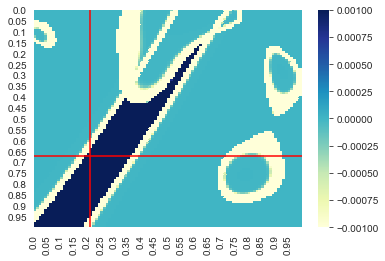

[array([[0.20930578, 0.67166248]]), array([[0.88433625]])]
Optimization restart 1/10, f = 14.215706109863177
Optimization restart 2/10, f = 14.215706090893462
Optimization restart 3/10, f = 14.215706116754944
Optimization restart 4/10, f = 14.215706083825097
Optimization restart 5/10, f = 14.215706087776027
Optimization restart 6/10, f = 14.215706085751052
Optimization restart 7/10, f = 14.215706088276775
Optimization restart 8/10, f = 14.215706084878008
Optimization restart 9/10, f = 14.215706084556274
Optimization restart 10/10, f = 14.215820309783837

Name : gp
Objective : 14.215706083825097
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    28.400385029443285  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.49421956761167346  |      +ve      |        

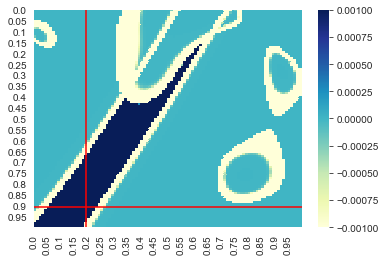

[array([[0.1945265, 0.9080003]]), array([[0.85585533]])]
Optimization restart 1/10, f = 12.158108164866938
Optimization restart 2/10, f = 12.158108202041525
Optimization restart 3/10, f = 12.158108162298127
Optimization restart 4/10, f = 12.158108162110459
Optimization restart 5/10, f = 12.158108161968308
Optimization restart 6/10, f = 12.158108173054323
Optimization restart 7/10, f = 12.158108164325043
Optimization restart 8/10, f = 12.15810816440213
Optimization restart 9/10, f = 12.158108162136095
Optimization restart 10/10, f = 12.158114563182039

Name : gp
Objective : 12.158108161968308
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                  value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     27.978026239173403  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.4908773743739462  |      +ve      |        

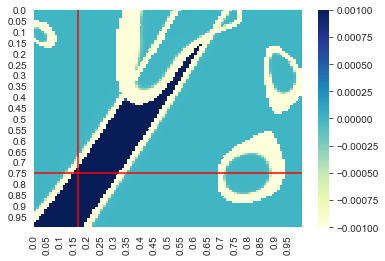

[array([[0.164035  , 0.75172144]]), array([[0.83603771]])]
Optimization restart 1/10, f = 11.033938875801645
Optimization restart 2/10, f = 11.03393887930271
Optimization restart 3/10, f = 11.033938878202257
Optimization restart 4/10, f = 11.033938874677204
Optimization restart 5/10, f = 11.033938904613414
Optimization restart 6/10, f = 11.033938875716835
Optimization restart 7/10, f = 11.033938878082772
Optimization restart 8/10, f = 11.033938876038107
Optimization restart 9/10, f = 11.033938875118196
Optimization restart 10/10, f = 11.033939418063568

Name : gp
Objective : 11.033938874677204
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     27.45616494222362  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.49010758578964464  |      +ve      |        


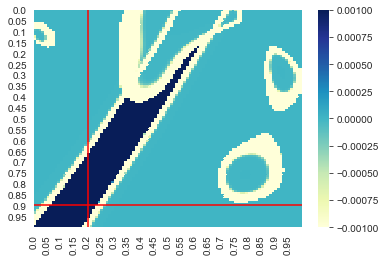

[array([[0.20390769, 0.89841422]]), array([[0.90649168]])]
Optimization restart 1/10, f = 9.5307748120387
Optimization restart 2/10, f = 9.530774810094712
Optimization restart 3/10, f = 9.530774810384017
Optimization restart 4/10, f = 9.530774810266635
Optimization restart 5/10, f = 9.530774810062198
Optimization restart 6/10, f = 9.530774809972442
Optimization restart 7/10, f = 9.530774811553115
Optimization restart 8/10, f = 9.530774809932808
Optimization restart 9/10, f = 9.530774809873947
Optimization restart 10/10, f = 9.530779400643667

Name : gp
Objective : 9.530774809873947
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    26.765874360323302  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.4848099333701204  |      +ve      |        
  Multioutpu

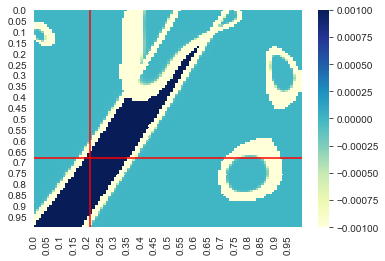

[array([[0.21066789, 0.68376058]]), array([[0.92113427]])]
Optimization restart 1/10, f = 7.143822547968959
Optimization restart 2/10, f = 7.1438225558231
Optimization restart 3/10, f = 7.143822549358973
Optimization restart 4/10, f = 7.143822597999986
Optimization restart 5/10, f = 7.143822549831185
Optimization restart 6/10, f = 7.143822549277999
Optimization restart 7/10, f = 7.143822549562216
Optimization restart 8/10, f = 7.143822549011688
Optimization restart 9/10, f = 7.143822550549807
Optimization restart 10/10, f = 7.143843910534123

Name : gp
Objective : 7.143822547968959
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     26.6714164857429  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.4841937223720237  |      +ve      |        
  MultioutputDe

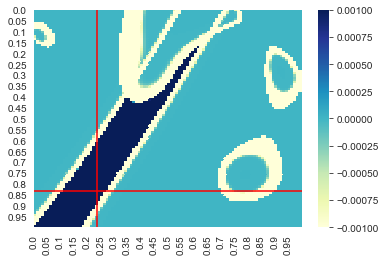

[array([[0.23719764, 0.83445848]]), array([[0.88169365]])]
Optimization restart 1/10, f = 4.878478444375148
Optimization restart 2/10, f = 4.8784784500223
Optimization restart 3/10, f = 4.878478448847616
Optimization restart 4/10, f = 4.87847847810967
Optimization restart 5/10, f = 4.878478445104207
Optimization restart 6/10, f = 4.878478444492856
Optimization restart 7/10, f = 4.878478454863142
Optimization restart 8/10, f = 4.87847844521302
Optimization restart 9/10, f = 4.878478450476223
Optimization restart 10/10, f = 4.878514824625469

Name : gp
Objective : 4.878478444375148
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     26.51295424112455  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |     0.482298186068816  |      +ve      |        
  MultioutputD

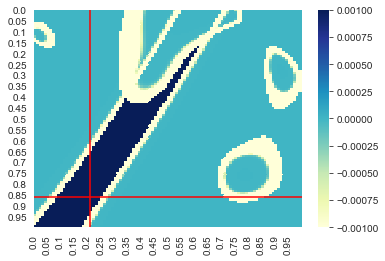

[array([[0.20997073, 0.86298097]]), array([[0.83158732]])]
Optimization restart 1/10, f = 3.72668930398153
Optimization restart 2/10, f = 3.726689303717407
Optimization restart 3/10, f = 3.726689306076537
Optimization restart 4/10, f = 3.7266893050631325
Optimization restart 5/10, f = 3.726689304876899
Optimization restart 6/10, f = 3.726689303326239
Optimization restart 7/10, f = 3.7266893032830666
Optimization restart 8/10, f = 3.726689303709918
Optimization restart 9/10, f = 3.726689303418212
Optimization restart 10/10, f = 3.726689747384455

Name : gp
Objective : 3.7266893032830666
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |    27.276194970151273  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |   0.48923852370843646  |      +ve      |        
  Multio

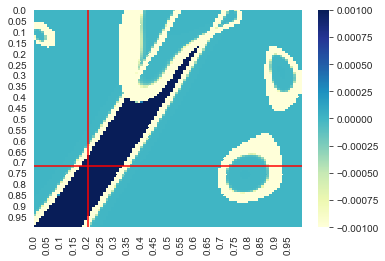

[array([[0.2016821 , 0.71678696]]), array([[0.88542259]])]
Optimization restart 1/10, f = 2.1756292959355648
Optimization restart 2/10, f = 2.175629293619309
Optimization restart 3/10, f = 2.175629293538549
Optimization restart 4/10, f = 2.175629293089443
Optimization restart 5/10, f = 2.175629294150937
Optimization restart 6/10, f = 2.1756292969110973
Optimization restart 7/10, f = 2.1756292935638584
Optimization restart 8/10, f = 2.1756292931050183
Optimization restart 9/10, f = 2.175629293135998
Optimization restart 10/10, f = 2.1756337348289208

Name : gp
Objective : 2.175629293089443
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                               |                 value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |     27.01804651676198  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |    0.4884489088694848  |      +ve      |        
  Mul

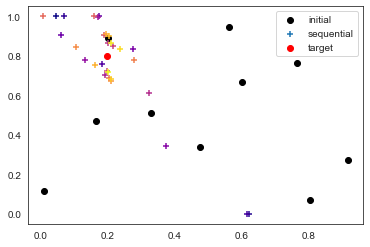

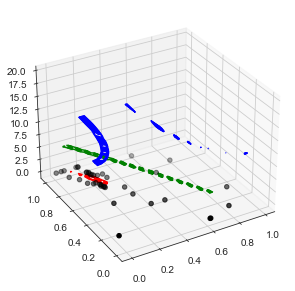

In [29]:
from GPy.kern.src.multioutput_kern import ZeroKern
bayesian_inference=False
batch_size = 1
#axis1 = get_values_aroud(true_param[0,0],0.5,100)
#axis2 = get_values_aroud(true_param[0,1],0.5,100)
axis1 = np.arange(lb[0], ub[0], 0.01)
axis2 = np.arange(lb[1], ub[1], 0.01)

BB, DD = np.meshgrid(axis1, axis2)
X_plot = np.array([BB.flatten(),DD.flatten()]).transpose()
for runNo in range(0,3):
    # initial points and initialize emulator
    X = lhs(n=2, samples=n_init, criterion='maximin', iterations=20)
    X[:,0] = (ub[0]-lb[0])*X[:,0]+lb[0]
    X[:,1] = (ub[1]-lb[1])*X[:,1]+lb[1]
    Y = f(X)
    max_iterations = int((n_total - len(X))/batch_size)
    # Put ARD true to select relevent dimensions automatically 
    kernel1 = RBF(input_dim=2)
    kernel2 = RBF(input_dim=2)
    model_gpy = MultioutputGP([X,X],Y,
                              likelihood_list=[likelihoods.Gaussian(variance=noise,name='Gaussian_noise'),
                                               likelihoods.Gaussian(variance=noise,name='Gaussian_noise')],
                              kernel_list=[kernel1,kernel2],) 
                              #kernel_cross_covariances={(0,1):ZeroKern(),(1,0):ZeroKern()} )
    #model_gpy = GPMultioutRegression(X, Y, )
    model_emukit = GPyMultiOutputWrapper(model_gpy, n_outputs=2, n_optimization_restarts=10, 
                                         verbose_optimization = True, parallel=True, num_processes=8)
    model_emukit.optimize()
    print(model_emukit.gpy_model)
    print(f'Run number {runNo}')
    print(f'Alphas {alpha_list[runNo]}')
    contour_MD = contourMinEI(modelwrapper = model_emukit, a_list = a_list, alpha_list = alpha_list[runNo],
                              w_list = w_list)
    expdesign_loop = ExperimentalDesignLoop(model = model_emukit,
                                             space = parameter_space,
                                             acquisition = contour_MD,
                                             batch_size = batch_size)

    #---# loop to generate designs
    for i in range(0,max_iterations):  
        # Compute next point
        optimizer = GradientAcquisitionOptimizer(parameter_space)
        xnew, opt_acq = optimizer.optimize(contour_MD)
        #Add our own optimization routine to see if the emukit optimization is stable. 
        print(xnew)
        fig, ax = plt.subplots()
        sns.heatmap(contour_MD.evaluate(X_plot).reshape(BB.shape), ax=ax, cmap="YlGnBu", vmin=-0.001, vmax=0.001)
        tick_labels = axis1[0::5]
        ticks = np.arange(0,100,5)
        ax.set_xticks(ticks)
        ax.set_xticklabels(np.round(tick_labels,2))
        tick_labels = axis2[0::5]
        ax.set_yticks(ticks)
        ax.set_yticklabels(np.round(tick_labels,2))
        ax.axvline(x=xnew[0,0]*100, color='red')
        ax.axhline(y=xnew[0,1]*100, color='red')
        #ax.scatter(true_param[0], true_param[1], marker='.', s=100)
        plt.savefig(f'figures/acqu_{alpha_list[runNo]}_{i}.png', dpi=50)
        plt.show()
        
        print([xnew,opt_acq])
        X0 = np.append(X[:,0],xnew[:,0])
        X1 = np.append(X[:,1],xnew[:,1])
        X = np.array([X0,X1]).transpose()
        y1 = np.append(Y[0],f(xnew)[0]).reshape(-1,1)
        y2 = np.append(Y[1],f(xnew)[1]).reshape(-1,1)
        Y = [y1,y2]
        model_gpy = MultioutputGP([X,X],Y,
                              likelihood_list=[likelihoods.Gaussian(variance=noise,name='Gaussian_noise'),
                                               likelihoods.Gaussian(variance=noise,name='Gaussian_noise')],
                              kernel_list=[kernel1,kernel2])
        model_emukit = GPyMultiOutputWrapper(model_gpy, n_outputs=2, n_optimization_restarts=10, 
                                             verbose_optimization = True, parallel=True, num_processes=8)
        model_emukit.optimize()
        print(model_emukit.gpy_model)
        contour_MD = contourMinEI(modelwrapper = model_emukit, a_list = a_list, alpha_list = alpha_list[runNo],
                                  w_list = w_list)
    
    #---# plot final samples
    n_end = len(X)
    fig, ax = plt.subplots()
    ax.scatter(X[0:n_init,0],X[0:n_init,1], color='black', label='initial')
    ax.scatter(X[n_init:n_end,0],X[n_init:n_end,1], c=np.arange(1,1+n_end-n_init), 
               cmap='plasma' , marker='+', label='sequential')
    ax.scatter(true_param[:,0], true_param[:,1], color='red', label='target')
    n = np.arange(0,X[0:n_end,:].shape[0])
    # for i, txt in enumerate(n):
    #     ax.annotate(txt, (X[i,0], X[i,1]))
    plt.legend()
    plt.savefig(f'figures/designs_{alpha_list[runNo]}.png', dpi=50)

    #---# plot contours
    fig = plt.figure(figsize = (5,5))
    ax = fig.gca(projection='3d')
    A = np.linspace(0, 1, 30)
    B = np.linspace(0, 1, 30)
    A, B = np.meshgrid(A, B)

    # ax.plot_surface(A, B, l(A,B), rstride=1, cstride=1, cmap = cm.viridis, antialiased=False, alpha = 0.5)
    # ax.plot_surface(A, B, g(A,B), rstride=1, cstride=1, cmap = cm.viridis, antialiased=False, alpha = 0.5)
    ax.contour(A, B, abs(l(A,B)-l(true_param[0][0],true_param[0][1])), 
               levels=list(np.linspace(0,0.1,10)), zdir='z', offset=10, colors='blue')
    ax.contour(A, B, abs(g(A,B)-g(true_param[0][0],true_param[0][1])),
               levels=list(np.linspace(0,0.3,10)), zdir='z', offset=5, colors='green')
    ax.contour(A, B, abs(l(A,B)-l(true_param[0][0],
                                  true_param[0][1]))+abs(g(A,B)-g(true_param[0][0],
                                  true_param[0][1])), levels=list(np.linspace(0,0.5,10)),
                                  zdir='z', offset=0, colors='red')
    ax.scatter(X[:,0], X[:,1], np.zeros(X.shape[0]), color='black') 
    ax.view_init(30, 240)
    plt.savefig(f'figures/contours_{alpha_list[runNo]}.png', dpi=50)
    if bayesian_inference==False:
        print('Skip Bayesian Inference')
        continue;
    #---# Bayesian inference
    X_final = X[0:n_end,:]
    Y_final = f(X_final)
    
    kernel1 = RBF(input_dim=2)
    kernel2 = RBF(input_dim=2)
    model_gpy = MultioutputGP([X_final,X_final],Y_final,
                              likelihood_list=[likelihoods.Gaussian(variance=noise,name='Gaussian_noise'),
                                               likelihoods.Gaussian(variance=noise,name='Gaussian_noise')],
                              kernel_list=[kernel1,kernel2])
    model = GPyMultiOutputWrapper(model_gpy, n_outputs=2, n_optimization_restarts=20, 
                                  verbose_optimization = False, parallel=True, num_processes=8)
    model.optimize()
    
    def emu_predict(xx, obsno):
        """This function handles the scaling and GP interpolation together, 
        returning our prediction in the ordinary observable space
        rather than the scaled observable space.
        This map is what we call our 'emulator'. """
        X = xx.reshape(-1, ndim)
        new_column = [[obsno]]*len(X)
        pred_temp = model.predict(np.append(X,new_column,axis=1))
        y = pred_temp[0] # vector of predictive means
        s2_vec = pred_temp[1]
        dy = np.sqrt(s2_vec)
        return y, dy

    def log_likelihood(theta, y_exp, dy_exp):
        '''Log-likelihood for data y_exp.'''
        #use our GP emulator for prediction
        log_lik = 0

        for obs in range(y_exp.shape[1]): # number of observables
            y_pred, s_pred = emu_predict(theta, obs) # emulation prediction and uncertainty
            sigma2 = s_pred**2. + dy_exp.flatten()[obs]**2. #total variance, emulation and exp.
            log_lik = log_lik - 0.5*np.log(2.*np.pi*sigma2) -0.5*( (y_pred - y_exp.flatten()[obs])**2 / sigma2 )

        return log_lik

    #posterior using flat prior
    def log_posterior_flat_prior(theta, y_exp, dy_exp):
        '''Log posterior for data y_exp and uncertainties 
            dy_exp given parameter array theta, assuming prior is flat.'''
        return log_flat_prior(theta) + log_likelihood(theta, y_exp, dy_exp)
    
    # ptemcee
    ntemps = 10
    nwalkers = 20
    # starting_guesses = np.ones(ntemps*nwalkers*ndim).reshape(ntemps,nwalkers,ndim)*0.5 + np.random.rand(ntemps,nwalkers,ndim) * 0.1
    starting_guesses = np.random.uniform(size=(ntemps,nwalkers,ndim))
    sampler = PTSampler(nwalkers, ndim, log_likelihood, log_flat_prior, ntemps=ntemps, loglargs=[y_exp, dy_exp])

    # burn in
    for p, lnprob, lnlike in sampler.sample(starting_guesses, iterations=100):
        pass
    sampler.reset()

    # record every 10
    for p, lnprob, lnlike in sampler.sample(p, iterations=500, thin=5):
        pass

    # resulting chains
    assert sampler.chain.shape == (ntemps, nwalkers, 100, ndim)

    # Chain has shape (ntemps, nwalkers, nsteps, ndim)
    # Zero temperature mean:
    mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)

    # Longest autocorrelation length (over any temperature)
    max_acl = np.max(sampler.acor)
    
    # plots & save data for R analysis
    prop_T0chain = sampler.chain[0,...].reshape(-1,ndim)
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.plot(prop_T0chain[:,0], '-', color='k', alpha=0.3)
    ax1.axhline(y=true_param[0][0], color='blue')
    ax1.title.set_text('theta1')

    ax2.plot(prop_T0chain[:,1], '-', color='k', alpha=0.3)
    ax2.axhline(y=true_param[0][1], color='blue')
    ax2.title.set_text('theta2')
    plt.show()

   # tmp = corner.corner(prop_T0chain, labels=['theta1','theta2'], 
   #                 truths=[true_param[0][0],true_param[0][1]])

   # MCMC_sim = pd.DataFrame(prop_T0chain)
   # MCMC_sim.to_csv('2d_2obs_Branin_LIM_MCMCprop'+str(runNo)+'.csv', index=False)
    

### 3. Random LHD Designs

#### Repeat 10 times

In [ ]:
for runNo in range(10):
    x_ref = lhs(n=2, samples=n_total) # no criterion specified: random design
    y_ref = f(x_ref)
    
    # train GP
    kernel1 = RBF(input_dim=2)
    kernel2 = RBF(input_dim=2)
    model_gpy = MultioutputGP([x_ref,x_ref],y_ref,
                              likelihood_list=[likelihoods.Gaussian(variance=noise,name='Gaussian_noise'),
                                               likelihoods.Gaussian(variance=noise,name='Gaussian_noise')],
                              kernel_list=[kernel1,kernel2])
    model_ref = GPyMultiOutputWrapper(model_gpy, n_outputs=2, n_optimization_restarts=20, verbose_optimization = False)
    model_ref.optimize()
    
    def emu_ref_predict(xx, obsno):
        """This function handles the scaling and GP interpolation together, 
        returning our prediction in the ordinary observable space
        rather than the scaled observable space.
        This map is what we call our 'emulator'. """
        X = xx.reshape(-1, ndim)
        new_column = [[obsno]]*len(X)
        pred_temp = model_ref.predict(np.append(X,new_column,axis=1))
        y = pred_temp[0] # vector of predictive means
        s2_vec = pred_temp[1]
        dy = np.sqrt(s2_vec)
        return y, dy
    
    # define log likelihood
    def log_likelihood_ref(theta, y_exp, dy_exp):
        '''Log-likelihood for data y_exp.'''
        #use our GP emulator for prediction
        log_lik = 0

        for obs in range(y_exp.shape[1]): # number of observables
            y_pred, s_pred = emu_ref_predict(theta, obs) # emulation prediction and uncertainty
            sigma2 = s_pred**2. + dy_exp.flatten()[obs]**2. #total variance, emulation and exp.
            log_lik = log_lik - 0.5*np.log(2.*np.pi*sigma2) -0.5*( (y_pred - y_exp.flatten()[obs])**2 / sigma2  )

        return log_lik
    
    #posterior using flat prior
    def log_posterior_flat_prior_ref(theta, y_exp, dy_exp):
        '''Log posterior for data y_exp and uncertainties 
            dy_exp given parameter array theta, assuming prior is flat.'''
        return log_flat_prior(theta) + log_likelihood_ref(theta, y_exp, dy_exp)

    
    # ptemcee
    # https://emcee.readthedocs.io/en/develop/user/pt/
    from emcee.ptsampler import PTSampler
    ntemps = 2
    nwalkers = 20
    # starting_guesses = np.ones(ntemps*nwalkers*ndim).reshape(ntemps,nwalkers,ndim)*0.5 + np.random.rand(ntemps,nwalkers,ndim) * 0.1
    starting_guesses = np.random.uniform(size=(ntemps,nwalkers,ndim))
    sampler = PTSampler(nwalkers, ndim, log_likelihood_ref, log_flat_prior, ntemps=ntemps, loglargs=[y_exp, dy_exp])

    # burn in
    for p, lnprob, lnlike in sampler.sample(starting_guesses, iterations=5000):
        pass
    sampler.reset()

    # record every 10
    for p, lnprob, lnlike in sampler.sample(p, iterations=1000, thin=10):
        pass

    # resulting chains
    assert sampler.chain.shape == (ntemps, nwalkers, 100, ndim)

    # Chain has shape (ntemps, nwalkers, nsteps, ndim)
    # Zero temperature mean:
    mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)

    # Longest autocorrelation length (over any temperature)
    max_acl = np.max(sampler.acor)
    
    
    # plots & save data for R analysis
    LHD_T0chain = sampler.chain[0,...].reshape(-1,ndim)
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.plot(LHD_T0chain[:,0], '-', color='k', alpha=0.3)
    ax1.axhline(y=true_param[0][0], color='blue')
    ax1.title.set_text('theta1')

    ax2.plot(LHD_T0chain[:,1], '-', color='k', alpha=0.3)
    ax2.axhline(y=true_param[0][1], color='blue')
    ax2.title.set_text('theta2')
    plt.show()

    tmp = corner.corner(LHD_T0chain, labels=['theta1','theta2'], 
                    truths=[true_param[0][0],true_param[0][1]])
    
    MCMC_LHD = pd.DataFrame(LHD_T0chain)
    MCMC_LHD.to_csv('2d_2obs_Branin_LIM_MCMCLHD'+str(runNo)+'.csv', index=False)
    